In [6]:
# conda create -n sss python=3.8 -y && conda activate sss
# pip install gffutils jupyter tqdm cyvcf2 pathlib2 pandarallel pysam liftover 
# conda install -y -c bioconda pybedtools

import os
import numpy as np
import pandas as pd
# from Bio.Seq import Seq
# from liftover import get_lifter
from pathlib2 import Path
from pandarallel import pandarallel
from tqdm import tqdm
import gffutils
import pysam
from cyvcf2 import VCF

### Logging setup
from logging import getLogger, config
import yaml
parent_directory = os.path.dirname(os.path.dirname('__file__'))

config_path: str = os.path.join(parent_directory, '../../../config/logging.yaml')
with open(config_path, 'r') as f:
    config.dictConfig(yaml.safe_load(f))
logger = getLogger(__name__)

########   Initialize and setup pandas methods   ########
os.environ['JOBLIB_TEMP_FOLDER'] = '/tmp' 
# pandarallel.initialize(nb_workers=os.cpu_count()-8, progress_bar=False, verbose=2, use_memory_fs=False) 
pandarallel.initialize(nb_workers=16, progress_bar=False, verbose=2, use_memory_fs=False) 

tqdm.pandas()


import sys
try: 
    __file__
    sys.path.append(os.path.join(os.path.dirname('__file__')))
except NameError:
    Path().resolve()
    sys.path.append(os.path.join(Path().resolve(), '../../../'))

from libs import utils, preprocess, variantfilter, posparser, splaiparser
# from libs import predeffect, scoring
from libs import anno_spliceai, anno_clinvar
from libs.deco import print_filtering_count
# from libs import predeffect
from libs.scoring import Scoring
from libs import predeffect


gencode_gff = '../../../Resources/05_GENCODE_v43lift37/gencode.v43lift37.annotation.sort.gff3.gz'

try:
    db_anno_gencode = '../../../Resources/06_gffutilsdb/gencode.v43lift37.annotation.gtf.db'
    db_anno_intron = '../../../Resources/06_gffutilsdb/gencode.v43lift37.annotation.intron.gtf.db'
    db = gffutils.FeatureDB(db_anno_gencode)
    db_intron = gffutils.FeatureDB(db_anno_intron)
except ValueError:
    db_anno_gencode = '/resources/DBs/gencode.v43lift37.annotation.gtf.db'
    db_anno_intron = '/resources/DBs/gencode.v43lift37.annotation.intron.gtf.db'
    db = gffutils.FeatureDB(db_anno_gencode)
    db_intron = gffutils.FeatureDB(db_anno_intron)

## Thresholds configuration
thresholds_SpliceAI_parser: dict = {
    'TH_min_sALDL': 0.02, 'TH_max_sALDL': 0.2, 
    'TH_min_sAGDG': 0.01, 'TH_max_sAGDG': 0.05,
    'TH_min_GExon': 25, 'TH_max_GExon': 500,
    'TH_sAG': 0.2, 'TH_sDG': 0.2
    }

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

try: 
    __file__
    sys.path.append(os.path.join(os.path.dirname('__file__')))
except NameError:
    Path().resolve()
    sys.path.append(os.path.join(Path().resolve(), '../../'))

from libs.scoring import Scoring

import warnings
warnings.simplefilter('ignore')

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [7]:
# 関数の設定
def specificity_sensitivity_plotly(data):
    thresholds = np.arange(0, 11, 1)
    results = []

    for threshold in thresholds:
        tp = data[(data['PriorityScore'] >= threshold) & (data['LABEL'] == 1)].shape[0]
        fn = data[(data['PriorityScore'] < threshold) & (data['LABEL'] == 1)].shape[0]
        tn = data[(data['PriorityScore'] < threshold) & (data['LABEL'] == 0)].shape[0]
        fp = data[(data['PriorityScore'] >= threshold) & (data['LABEL'] == 0)].shape[0]
        specificity = tn / (tn + fp) if (tn + fp) else 0
        sensitivity = tp / (tp + fn) if (tp + fn) else 0
        # print(f"Threshold: {threshold}, TP: {tp}, FN: {fn}, TN: {tn}, FP: {fp}")
        # print(f"Threshold: {threshold}, Specificity: {specificity:.6f}, Sensitivity: {sensitivity:.6f}")
        results.append({'Threshold': threshold, 'Metric': 'Specificity', 'Value': specificity})
        results.append({'Threshold': threshold, 'Metric': 'Sensitivity', 'Value': sensitivity})

    results_df = pd.DataFrame(results)
    return results_df

def plot_sensitivity_specificity_plotly(
        results_df: pd.DataFrame, w: int, h: int):
    # Separate the dataframes for specificity and sensitivity
    specificity_df = results_df[results_df['Metric'] == 'Specificity']
    sensitivity_df = results_df[results_df['Metric'] == 'Sensitivity']

    # Plotly Graph Objectsを使用してプロット
    fig = go.Figure()

    # 特異性
    fig.add_trace(go.Scatter(
        x=specificity_df['Threshold'],
        y=specificity_df['Value'],
        marker=dict(color='#665990'),
        mode='lines+markers',
        name='Specificity',
        text=[f'Threshold: {th}, Specificity: {val:.3f}' for th, val in zip(specificity_df['Threshold'], specificity_df['Value'])],
        hoverinfo='text'
    ))
    
    # 感度
    fig.add_trace(go.Scatter(
        x=sensitivity_df['Threshold'],
        y=sensitivity_df['Value'],
        marker=dict(color='#F8ACAC'),
        mode='lines+markers',
        name='Sensitivity',
        text=[f'Threshold: {th}, Sensitivity: {val:.3f}' for th, val in zip(sensitivity_df['Threshold'], sensitivity_df['Value'])],
        hoverinfo='text'
    ))

    # Y軸のフォーマット設定
    fig.update_yaxes(tickformat=".1f")

    # グラフのレイアウト設定
    fig.update_layout(title='Sensitivity and Specificity for each threshold',
                      xaxis_title='Threshold',
                      yaxis_title='Sensitivity/Specificity',
                      plot_bgcolor='rgba(243, 243, 243, 1)',
                      paper_bgcolor='rgba(243, 243, 243, 0)',
                      font=dict(family="Arial, sans-serif", size=12, color="black"),
                      legend=dict(y=0.075, x=0.75, xanchor='right', yanchor='bottom', 
                              bgcolor='rgba(243, 243, 243, 1)',
                              font=dict(family="Arial, sans-serif", size=12, color="black"))
                              )

    # グラフサイズの調整
    fig.update_layout(width=w, height=h)
    fig.write_html("sensitivity_specificity_plot.html")

    # fig.show()
    return fig

def plot_sensitivity_specificity_plotly_without_legened(results_df):
    # Separate the dataframes for specificity and sensitivity
    specificity_df = results_df[results_df['Metric'] == 'Specificity']
    sensitivity_df = results_df[results_df['Metric'] == 'Sensitivity']

    # Plotly Graph Objectsを使用してプロット
    fig = go.Figure()

    # 特異性
    fig.add_trace(go.Scatter(
        x=specificity_df['Threshold'],
        y=specificity_df['Value'],
        marker=dict(color='green'),
        mode='lines+markers',
        name='Specificity',
        text=[f'Threshold: {th}, Specificity: {val:.8f}' for th, val in zip(specificity_df['Threshold'], specificity_df['Value'])],
        hoverinfo='text',
        showlegend=False 
    ))
    
    # 感度
    fig.add_trace(go.Scatter(
        x=sensitivity_df['Threshold'],
        y=sensitivity_df['Value'],
        marker=dict(color='orange'),
        mode='lines+markers',
        name='Sensitivity',
        text=[f'Threshold: {th}, Sensitivity: {val:.8f}' for th, val in zip(sensitivity_df['Threshold'], sensitivity_df['Value'])],
        hoverinfo='text',
        showlegend=False
    ))

    # Y軸のフォーマット設定
    fig.update_yaxes(tickformat=".1f")

    # グラフのレイアウト設定
    fig.update_layout(title='Sensitivity and Specificity for each threshold',
                      xaxis_title='Threshold',
                      yaxis_title='Sensitivity/Specificity',
                      plot_bgcolor='rgba(243, 243, 243, 1)',
                      paper_bgcolor='rgba(243, 243, 243, 0)',
                      font=dict(family="Arial, sans-serif", size=12, color="black"),
                      legend=dict(y=0.075, x=0.75, xanchor='right', yanchor='bottom', 
                              bgcolor='rgba(243, 243, 243, 1)',
                              font=dict(family="Arial, sans-serif", size=12, color="black"))
                              )

    # グラフサイズの調整
    fig.update_layout(width=600, height=600)
    fig.write_html("sensitivity_specificity_plot.html")

    # fig.show()
    return fig


# Code below is adapted from Netflix's VMAF and BesenbacherLab's ROC-utils
# https://github.com/Netflix/vmaf/
# https://github.com/BesenbacherLab/ROC-utils
# Modifications: np.float -> np.float64

def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float64)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float64)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Operating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float64)
    ty = np.empty([k, n], dtype=np.float64)
    tz = np.empty([k, m + n], dtype=np.float64)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count


def delong_roc_variance(ground_truth, predictions):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


def delong_roc_test(ground_truth, predictions_one, predictions_two):
    """
    Computes log(p-value) for hypothesis that two ROC AUCs are different
    Args:
       ground_truth: np.array of 0 and 1
       predictions_one: predictions of the first model,
          np.array of floats of the probability of being class 1
       predictions_two: predictions of the second model,
          np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    return calc_pvalue(aucs, delongcov)

# Calculate AUC confidence interval (95%)
def compute_auc_confidence_interval(auc, var, confidence_level=0.95):
    alpha = 1 - confidence_level
    z_score = scipy.stats.norm.ppf(1 - alpha/2)  # 2-tailed z score
    se = np.sqrt(var)  # Calculate SE from variance
    lower_bound = auc - z_score * se
    upper_bound = auc + z_score * se
    return lower_bound, upper_bound



#### 処理済み - 前処理1. SQLで抽出したallmut.csvを編集する．

In [ ]:
all_mut_default_colnames: list = [
    "disase", "gene", "chrom", "genename", "gdbid", "omimid", "amino", 
    "deletion", "insertion", "codon", "codonAff", "descr", "refseq", "hgvs", 
    "hgvsAll", "dbsnp", "chromosome", "startCoord", "endCoord", 
    "expected_inheritance", "gnomad_AC", "gnomad_AF", "gnomad_AN", "tag", 
    "dmsupport", "rankscore", "mutype", "author", "title", "fullname", 
    "allname", "vol", "page", "year", "pmid", "pmidAll", "reftag", "comments", 
    "acc_num", "new_date", "base", "clinvarID", "clinvar_clnsig"
]

allmut: pd.DataFrame = pd.read_csv(
    'allmut.csv', sep=';', encoding='cp1252', names=all_mut_default_colnames, 
    skiprows=1,low_memory=False)

allmut = allmut[
    ["gene", "genename", "mutype", "clinvar_clnsig", "tag",
     "refseq", "hgvs", "hgvsAll", "chromosome", "startCoord", "endCoord", 
     "amino", "deletion", "insertion", "expected_inheritance", "gnomad_AF"]]

# Drop non-numeric values in 'startCoord'
allmut = allmut.dropna(subset=['startCoord'])

# Drop duplicates in 'chrom', 'startCoord', and 'endCoord'
allmut = allmut.drop_duplicates(subset=['chromosome', 'startCoord', 'endCoord'])

# Extract tag == "DM" from allmut
allmut_dm = allmut[allmut.tag == "DM"].copy()
print(f"A total of {len(allmut_dm)} DM mutations are found in allmut.")

allmut_dm['startCoord'] = allmut_dm['startCoord'].astype(int)
allmut_dm = allmut_dm.rename(columns={'chromosome': 'CHROM', 'startCoord': 'POS_hg38'})

# Fillna with empty string in "gnomad_AF" colmun in allmut_dm
# Extratct MAF 0 from allmut_dm
allmut_dm['gnomad_AF'].fillna(0, inplace=True)
allmut_dm_maf0 = allmut_dm[allmut_dm['gnomad_AF'] == 0].copy()
print(f"A total of {len(allmut_dm_maf0)} DM mutations are found in allmut with MAF 0.")

# Extract non-deletion or non-insertion from allmut_dm
allmut_dm_maf0_snv = allmut_dm_maf0[(allmut_dm_maf0['deletion'].isnull()) & (allmut_dm_maf0['insertion'].isnull())]
print(f"A total of {len(allmut_dm_maf0_snv)} DM mutations are found in allmut with MAF 0 and non-deletion or non-insertion.")

# Extract the mutation type from the mutype column
splice_mutations = allmut_dm_maf0_snv[allmut_dm_maf0_snv["mutype"].str.contains("splice")].copy()
non_splice_mutations = allmut_dm_maf0_snv[~allmut_dm_maf0_snv["mutype"].str.contains("splice")]
print(f"Splicing_DM: {len(splice_mutations)}, Non-splicing_DM: {len(non_splice_mutations)}")

# Convert startCoord to hg19
from liftover import get_lifter

def _liftover_to_hg19(chrom, pos):
    converter = get_lifter('hg38', 'hg19')
    result = converter.query(chrom, pos)
    if result:
        return result[0]
    else:
        return None
    
def anno_hg19_pos(row):
    converted = _liftover_to_hg19(row['CHROM'], row['POS_hg38'])
    if converted:
        return converted[0]
    else:
        return None

allmut_dm_maf0_snv['POS_hg19'] = allmut_dm_maf0_snv.parallel_apply(anno_hg19_pos, axis=1)
# allmut_dm_maf0_snv.to_pickle('allmut_dm_maf0_snv_liftover.pkl', mode='x')

##### 計算済み - 重みづけのパターンの探索

In [3]:
from ortools.sat.python import cp_model

class SolutionCollector(cp_model.CpSolverSolutionCallback):
    def __init__(self, variables):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.__variables = variables
        self.__solutions = []

    def OnSolutionCallback(self):
        solution = {v.Name(): self.Value(v) for v in self.__variables}
        self.__solutions.append(solution)

    def GetAllSolutions(self):
        return self.__solutions

def find_all_solutions(lowerlimit: int):
    # Initialize the model
    model = cp_model.CpModel()

    # Define the variables (s1, s2, ..., s15)
    s = {i: model.NewIntVar(lowerlimit, 5, f's{i}') for i in range(1, 16)}

    """
    Rule 1	Score 1 > Score 2 > Score 3 = 0 > Score 15
    Rule 2	Score 9 ≥ Score 7 > Score 6 ≥ 0 ≥ Score 5 > Score 4
    Rule 3	Score 10 > Score 8 > Score 9 > Score 11 ≥ 0
    Rule 4	Score 14 > 0 ≥ Score 13 ≥ Score 4 ≥ Score12
    Rule 5	Score 1 + Score 10 + Score 14 = 9
    Rule 6	Score 3 + Score 11 + Score 12 = 0
            Score 15 + Score 4 
    """
    # Add constraints
    # Rule 1: 
    # Most higheset score 
    # model.Add(s[1] + s[10] + s[14] == 9)
    # model.Add(s[15] + s[10] + s[14] == 0)

    # Baseline constraints
    # model.Add(s[15] + s[4] <= 0)
    # model.Add(s[3] + s[11] + s[12] == 0)    #
    # model.Add(s[15] + s[11] + s[12] == 0)    #
    # model.Add(s[1] + s[7] < 9)
    # model.Add(s[1] == 3)

    
    """
    Maximum: s[1] + s[10] + s[14]
    Minimum: s[15] + s[4]
    Max - min > 9
    """
    # model.Add(s[1] + s[10] + s[14] - s[15] - s[4] > 9)

    # Knowledge-based
    # s[15] < 0 = s[3] < s[2] < s[1]
    model.Add(s[15] < 0)
    model.Add(0 == s[3])
    model.Add(s[3] < s[2])
    model.Add(s[2] < s[1])  

    # s[4] < s[5] < 0 <= s[6] < s[7] <= s[9] < s[8] < s[10]
    model.Add(s[4] < s[5])
    model.Add(s[5] < 0)
    model.Add(0 <= s[6])
    model.Add(s[6] < s[7])  
    model.Add(s[7] <= s[9])  
    model.Add(s[9] < s[8])
    model.Add(s[8] < s[10])  
    
    # 0 < s[11] && s[6] <= s[11] <= s[9]
    model.Add(0 < s[11])
    model.Add(s[6] <= s[11])
    model.Add(s[11] <= s[9]) 

    """
    ClinVarでは, Benignだけど, CaonicalでSpliceAIも高く病原性が疑われそうな
    バリアントをPriortiyScore 0 とした.
    s[15] + s[10] + s[14] = 0
    """
    model.Add(s[15] + s[10] + s[14] == 0)

    """
    canonical splice siteのバリアントは, ClinGenのガイドラインを参考にすると, 
    insilico予測ツールの結果をあまり重視していないようだ. 
    そのため, s[14] < s[11] という制約を追加した．
    s[12] < 0 && 0 < s[14] && s[12] < s[13] < s[14] < s[11]
    """
    model.Add(s[12] < 0)
    model.Add(s[12] < s[13])
    model.Add(s[13] < s[14])
    model.Add(0 < s[14])
    model.Add(s[14] < s[11])

    # model.Add(s[1] + s[10] + s[14] - s[15] - s[4] > 9)

    # Create a solver and solve the model
    solver = cp_model.CpSolver()
    solution_collector = SolutionCollector([s[i] for i in range(1, 16)])
    solver.SearchForAllSolutions(model, solution_collector)
    
    # Return all solutions
    return solution_collector.GetAllSolutions()

# Find all solutions

for lowerlimit in range(-5, -4):
    all_solutions = find_all_solutions(lowerlimit=lowerlimit)
    print(f'Total solutions found (lowerlimit {lowerlimit}): {len(all_solutions)}')

# #Debug and confirm the solutions
# for index, solution in enumerate(all_solutions):
#     print(f'Solution {index + 1}: {solution}')



Total solutions found (lowerlimit -5): 4500


In [8]:
all_solutions_pkl = 'all_solutions_-5-5.pkl'

In [10]:
# Save a pickle for the results of ortools
import pickle
with open(all_solutions_pkl, 'wb') as f:
    pickle.dump(all_solutions, f)

#### [ここから解析] TPとTNの読み込み (HGMDのVCFとTSVの結合含む)

In [8]:
# Loading allmut variants from pickle
allmut_dm_maf0_snv_hg19 = pd.read_pickle('allmut_dm_maf0_snv_liftover.pkl')

# Rename POS_hg19 to POS
allmut_dm_maf0_snv_hg19.rename(columns={'POS_hg19': 'POS'}, inplace=True)

# Drop unknown positions in 'POS' column and assign integer type
allmut_dm_maf0_snv_hg19.dropna(subset=['POS'], inplace=True)
allmut_dm_maf0_snv_hg19 = allmut_dm_maf0_snv_hg19.astype({'POS': int})

# Change object name to allmut
allmut = allmut_dm_maf0_snv_hg19

# Generate ID column
allmut['ID'] = allmut['CHROM'].astype(str) + '-' + allmut['POS'].astype(str) + '-' + allmut['hgvs']

# Extract useful columns
allmut = allmut[['ID', 'mutype', 'clinvar_clnsig', 'tag', 'deletion', 'insertion', 'expected_inheritance', 'gnomad_AF']]

# Load VCF file annoteted by analysis pipeline
df = pd.read_pickle("variant_data_set_vcfs/hgmd_all.prescore.onlyhgnc.pkl")

df['HGVSc'] = df['HGVSc'].str.replace('c.', '')
df['ID'] = df['CHROM'].astype(str) + '-' + df['POS'].astype(str) + '-' + df['HGVSc']

# merge df and allmut on 'ID' column with inner join
print(len(df))
df = pd.merge(df, allmut, on='ID', how='inner')
print(len(df))

exclude_csq = {
    '3_prime_UTR_variant', '5_prime_UTR_variant', 'mature_miRNA_variant',
    'mature_miRNA_variant', 'downstream_gene_variant', 'upstream_gene_variant',
    'non_coding_transcript_exon_variant'
}

exclude_non_spl_dm: set = {'splice_region_variant'}

def is_orf_variants(row):
    csqs: list = row['Consequence'].split('&')
    if set(csqs).isdisjoint(exclude_csq):
        return True
    else:
        return False
    
def is_non_spl_tn(row):
    csqs: list = row['Consequence'].split('&')
    if set(csqs).isdisjoint(exclude_non_spl_dm):
        return True
    else:
        return False

def is_gnomad_tn(row):
    if row['gnomad_AF'] == 0:
        return True
    else:
        return False


df = df[df.apply(is_orf_variants, axis=1)]

# df_spl contains splicing mutations (splice, canonical-splice, exonic-splice)
df_spl = df[df['mutype'].str.contains('splice')].copy()

# df_non_spl contains non-splicing mutations
df_non_spl = df[df['mutype'].str.contains('missense|nonsense|synonymous')].copy()
# df_non_spl = df[df['mutype'].str.contains('missense|synonymous')].copy()
# df_non_spl = df[df['mutype'].str.contains('missense|nonsense')].copy()
# df_non_spl = df[df['mutype'].str.contains('missense')].copy()
# df_non_spl = df[df['mutype'].str.contains('synonymous')].copy()
# df_non_spl = df[df['mutype'].str.contains('nonsense')].copy()

df_non_spl = df_non_spl[df_non_spl.apply(is_non_spl_tn, axis=1)]

print(f"Splicing: {len(df_spl)}, Non-splicing: {len(df_non_spl)}, total: {len(df_spl) + len(df_non_spl)}")

179423
126859
Splicing: 18432, Non-splicing: 102095, total: 120527


In [9]:
### When mutype is splice, the label is 1, otherwise 0
df_gnomad = pd.read_pickle('variant_data_set_vcfs/gnomad_all.prescore.onlyhgnc.pkl')
df_gnomad = df_gnomad[df_gnomad.apply(is_orf_variants, axis=1)]

df_spl['LABEL'] = 1
df_non_spl['LABEL'] = 0
df_gnomad['LABEL'] = 0

### Annotating the label and variant_id (CHROM-POS-REF-ALT)
df_spl['variant_id'] = df_spl['CHROM'].astype(str) + '-' + df_spl['POS'].astype(str) + '-' + df_spl['REF'] + '-' + df_spl['ALT']
df_non_spl['variant_id'] = df_non_spl['CHROM'].astype(str) + '-' + df_non_spl['POS'].astype(str) + '-' + df_non_spl['REF'] + '-' + df_non_spl['ALT']
df_gnomad['variant_id'] = df_gnomad['CHROM'].astype(str) + '-' + df_gnomad['POS'].astype(str) + '-' + df_gnomad['REF'] + '-' + df_gnomad['ALT']

### Create a dataframe tp (True Positive)
tp = df_spl.copy()

# Concatenate df_gnomad and df_non_spl
# n = int(len(tp) / 2)
# df_non_spl = df_non_spl.sample(n=int(n/10), random_state=42)
# df_gnomad = df_gnomad.sample(n=n, random_state=42)
tn = pd.concat([df_gnomad, df_non_spl], ignore_index=True)
tn = tn.drop_duplicates(subset=['variant_id'], keep='first')

# tn = df_non_spl.copy()
tn = df_gnomad.copy()

### Exclude non-ORF variants
tn['is_ORF'] = tn.apply(is_orf_variants, axis=1)
tn = tn[tn['is_ORF']]

## Summary of the dataset
print(f"TP: {len(tp)}, TN: {len(tn)}")

TP: 18432, TN: 78048


### trainとtestのデータセットの分割

In [10]:
######   Setttings for train_test_split   ######
test_size = 0.2
random_state = 13

In [11]:
from sklearn.model_selection import train_test_split

print(f"TP: {len(tp)}, TN: {len(tn)}")
tp = tp[tp['ENST_Full'] != "[Warning] ENST_with_Ver_not_available"]
tn = tn[tn['ENST_Full'] != "[Warning] ENST_with_Ver_not_available"]
tp = tp[tp['maxsplai'] != "NA"]
tn = tn[tn['maxsplai'] != "NA"]
print(f"Filtered out [Warning] ENST_with_Ver_not_available, TP: {len(tp)}, TN: {len(tn)}")

## Scoring without final recalibration
scoring = Scoring()
tp['insilico_screening'] = tp.parallel_apply(scoring.insilico_screening, axis=1)
tp['clinvar_screening'] = tp.parallel_apply(scoring.clinvar_screening, axis=1)
tp['recalibrated_splai'] = tp.parallel_apply(scoring.recal_scores_in_canon, axis=1)
tn['insilico_screening'] = tn.parallel_apply(scoring.insilico_screening, axis=1)
tn['clinvar_screening'] = tn.parallel_apply(scoring.clinvar_screening, axis=1)
tn['recalibrated_splai'] = tn.parallel_apply(scoring.recal_scores_in_canon, axis=1)



# Generate TP and TN datasets
tp_train, tp_test = train_test_split(tp, test_size=test_size, random_state=random_state)
tn_train, tn_test = train_test_split(tn, test_size=test_size, random_state=random_state)

print("=== Dataset ===")
print(f"TP: {len(tp)}, TN: {len(tn)}")
print(f"TP_train: {len(tp_train)}, TN_train: {len(tn_train)}")
print(f"TP_test: {len(tp_test)}, TN_test: {len(tn_test)}")

## Save as pickle files
tp_train.to_pickle(f"train_test_pkls/tp_train_{test_size}-{random_state}.pkl")
tn_train.to_pickle(f"train_test_pkls/tn_train_{test_size}-{random_state}.pkl")
tp_test.to_pickle(f"train_test_pkls/tp_test_{test_size}-{random_state}.pkl")
tn_test.to_pickle(f"train_test_pkls/tn_test_{test_size}-{random_state}.pkl")

TP: 18432, TN: 78048
Filtered out [Warning] ENST_with_Ver_not_available, TP: 17258, TN: 72199
=== Dataset ===
TP: 17258, TN: 72199
TP_train: 13806, TN_train: 57759
TP_test: 3452, TN_test: 14440


#### ブートストラップ法で性能評価

##### 1. 最終的な重み付けの決定

In [14]:
start = [0, 4050, 8100, 12150]

results_1 = pd.read_pickle(f'results/results_{start[0]}_to_end.pkl')
df1 = pd.DataFrame(results_1)
results_2 = pd.read_pickle(f'results/results_{start[1]}_to_end.pkl')
df2 = pd.DataFrame(results_2)
results_3 = pd.read_pickle(f'results/results_{start[2]}_to_end.pkl')
df3 = pd.DataFrame(results_3)
results_4 = pd.read_pickle(f'results/results_{start[3]}_to_end.pkl')
df4 = pd.DataFrame(results_4)

df = pd.concat([df1, df2, df3, df4], ignore_index=True)
df = pd.concat([df.drop(['solution'], axis=1), df['solution'].apply(pd.Series)], axis=1)

def calc_sample_var(row) -> float:
    score_arr = np.array([row['s1'], row['s2'], row['s3'], row['s4'], row['s5'],
                          row['s6'], row['s7'], row['s8'], row['s9'], row['s10'], 
                          row['s11'], row['s12'], row['s13'], row['s14'], row['s15']])
    return np.var(score_arr)

df['sample_var'] = df.apply(calc_sample_var, axis=1)
df_max_auc = df.loc[df['AUC'] == df['AUC'].max(), :]
solution = df_max_auc.iloc[0, 1:].to_dict()
solution.pop('AUC')
solution.pop('CI_lower')
solution.pop('CI_upper')
solution.pop('sample_var')

print(f"Max AUC: {df['AUC'].max()}")
print(f"The number of solutions with the max AUC: {len(df_max_auc)}")
print(f"Solution with the max AUC: {solution}")

Max AUC: 0.9910536326472386
The number of solutions with the max AUC: 1
Solution with the max AUC: {'s1': 9.0, 's2': 6.0, 's3': 0.0, 's4': -5.0, 's5': -3.0, 's6': 0.0, 's7': 2.0, 's8': 3.0, 's9': 2.0, 's10': 4.0, 's11': 2.0, 's12': -1.0, 's13': 0.0, 's14': 1.0, 's15': -5.0, 's0': 0.0}


##### 2. 重み付けを適応してPriorityScoreをつける

In [15]:
def map_and_calc_score(row, score_map: dict) -> int:
    return int(score_map[row['recalibrated_splai']]) + int(score_map[row['insilico_screening']]) + int(score_map[row['clinvar_screening']])

# Load test data
tp_test = pd.read_pickle(f'train_test_pkls/tp_test_{test_size}-{random_state}.pkl')
tn_test = pd.read_pickle(f'train_test_pkls/tn_test_{test_size}-{random_state}.pkl')

##########################
tp_test = tp
tn_test = tn
##########################

# Calculate PriorityScore
tp_test['PriorityScore'] = tp_test.parallel_apply(
    map_and_calc_score, args=(solution,), axis=1)
tn_test['PriorityScore'] = tn_test.parallel_apply(
    map_and_calc_score, args=(solution,), axis=1)

##### 3. auROCの算出．欠損値は削除して計算した．（欠損値が多いほど過大評価する可能性ある．）

In [16]:
data = pd.concat([tp_test, tn_test], ignore_index=True)
data.drop_duplicates(subset='variant_id', keep=False, inplace=True)
data.loc[data['maxentscan_diff'] == '', 'maxentscan_diff'] = np.nan
data['maxentscan_diff'] = data['maxentscan_diff'].astype(float)
data['maxentscan_diff_abs'] = data['maxentscan_diff'].abs()

data = data[data['PriorityScore'] != 'Not available']
data['LABEL'] = data['LABEL'].astype(int)
data['PriorityScore'] = data['PriorityScore'].astype(float)
data['maxsplai'] = data['maxsplai'].astype(float)
data2 = data.copy()
data2= data2.dropna(subset=['maxentscan_diff_abs'])
data2['maxentscan_diff_abs'] = data2['maxentscan_diff_abs'].astype(float)
data['maxpangolin'] = data['maxpangolin'].astype(float)
data.loc[data['Squirls'] == "NA", 'Squirls'] = np.nan
data3 = data.copy()
data3 = data3.dropna(subset=['Squirls'])
data3['Squirls'] = data3['Squirls'].astype(float)

## DeLong test and AUC confidence interval
ground_truth = np.array(data['LABEL'])
ground_truth2 = np.array(data2['LABEL'])
ground_truth3 = np.array(data3['LABEL'])
predictions_fw = np.array(data['PriorityScore'])
predictions_sp = np.array(data['maxsplai'])
predictions_en = np.array(data2['maxentscan_diff_abs'])
predictions_pa = np.array(data['maxpangolin'])
predictions_sq = np.array(data3['Squirls'])

auc1, var1 = delong_roc_variance(ground_truth, predictions_fw)
cilower1, ciupper1 = compute_auc_confidence_interval(auc1, var1)
auc2, var2 = delong_roc_variance(ground_truth, predictions_sp)
cilower2, ciupper2 = compute_auc_confidence_interval(auc2, var2)
auc3, var3 = delong_roc_variance(ground_truth2, predictions_en)
cilower3, ciupper3 = compute_auc_confidence_interval(auc3, var3)
auc4, var4 = delong_roc_variance(ground_truth, predictions_pa)
cilower4, ciupper4 = compute_auc_confidence_interval(auc4, var4)
auc5, var5 = delong_roc_variance(ground_truth3, predictions_sq)
cilower5, ciupper5 = compute_auc_confidence_interval(auc5, var5)

p_value_log = delong_roc_test(ground_truth, predictions_fw, predictions_sp)

print(f"AUC - Framework (95%CI): {auc1:.3f} [{cilower1:.4f}-{ciupper1:.4f}]")
print(f"AUC - SpliceAI (95%CI) : {auc2:.3f} [{cilower2:.4f}-{ciupper2:.4f}]")
print(f"p-value (DeLong Test)  : {10**p_value_log[0][0]:.2e}")
print("===========================================================")
print(f"AUC - MaxEntScan (95%CI): {auc3:.3f} [{cilower3:.4f}-{ciupper3:.4f}]")
print(f"AUC - MaxPangolin (95%CI): {auc4:.3f} [{cilower4:.4f}-{ciupper4:.4f}]")
print(f"AUC - Squirls (95%CI): {auc5:.3f} [{cilower5:.4f}-{ciupper5:.4f}]")

# 欠損値の数の比較
print("===========================================================")
print("Show the number of missing values")
print(f"Data1: {len(data) - len(data.dropna(subset=['maxsplai']))}")
print(f"Data2: {len(data) - len(data2.dropna(subset=['maxentscan_diff_abs']))}")
print(f"Data3: {len(data) - len(data3.dropna(subset=['Squirls']))}")


AUC - Framework (95%CI): 0.991 [0.9900-0.9919]
AUC - SpliceAI (95%CI) : 0.983 [0.9821-0.9849]
p-value (DeLong Test)  : 2.11e-35
AUC - MaxEntScan (95%CI): 0.980 [0.9781-0.9823]
AUC - MaxPangolin (95%CI): 0.951 [0.9480-0.9532]
AUC - Squirls (95%CI): 0.982 [0.9807-0.9834]
Show the number of missing values
Data1: 0
Data2: 66930
Data3: 278


##### 4. ROCカーブのプロット

In [17]:
import plotly.graph_objects as go
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

# ROC curve (LABEL, PriorityScore)
fpr1, tpr1, thresholds1 = roc_curve(data['LABEL'], data['PriorityScore'])
auc1 = roc_auc_score(data['LABEL'], data['PriorityScore'])
fpr2, tpr2, thresholds2 = roc_curve(data['LABEL'], data['maxsplai'])
auc2 = roc_auc_score(data['LABEL'], data['maxsplai'])
fpr3, tpr3, thresholds3 = roc_curve(data2['LABEL'], data2['maxentscan_diff_abs'])
auc3 = roc_auc_score(data2['LABEL'], data2['maxentscan_diff_abs'])
fpr4, tpr4, thresholds4 = roc_curve(data['LABEL'], data['maxpangolin'])
auc4 = roc_auc_score(data['LABEL'], data['maxpangolin'])
fpr5, tpr5, thresholds5 = roc_curve(data3['LABEL'], data3['Squirls'])
auc5 = roc_auc_score(data3['LABEL'], data3['Squirls'])

# Calculate optimal threshold from ROC curve by Youden's J statistic
Youden_index = np.argmax(tpr1 - fpr1)
optimal_threshold = thresholds1[Youden_index]
print(f'Optimal threshold (using Youden index) - Framework: {optimal_threshold}')
youden_maxent = np.argmax(tpr3 - fpr3)
optimal_threshold_maxent = thresholds3[youden_maxent]
thr_maxent = np.round(optimal_threshold_maxent, 2)
print(f'Optimal threshold (using Youden index) - MaxEntScan: {optimal_threshold_maxent} ({thr_maxent})')
youden_pangolin = np.argmax(tpr4 - fpr4)
optimal_threshold_pangolin = thresholds4[youden_pangolin]
thr_pango = np.round(optimal_threshold_pangolin, 2)
print(f'Optimal threshold (using Youden index) - Pangolin: {optimal_threshold_pangolin} ({thr_pango})')
youden_squirls = np.argmax(tpr5 - fpr5)
optimal_threshold_squirls = thresholds5[youden_squirls]
thr_squir = np.round(optimal_threshold_squirls, 2)
print(f'Optimal threshold (using Youden index) - Squirls: {optimal_threshold_squirls} ({thr_squir})')

# 参考資料 SpliceAIのYouden index
youden_splai = np.argmax(tpr2 - fpr2)
optimal_threshold_spliceai = thresholds2[youden_splai]
print(f'Optimal threshold (using Youden index) - SpliceAI: {optimal_threshold_spliceai}')

# plot ROC curve using Plotly
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(
    x=fpr1, y=tpr1, mode='lines', 
    name=f"Framework      ({auc1:.3f} [{cilower1:.4f}-{ciupper1:.4f}])", 
    line=dict(color='#E41A1C', width=2))
    )
fig.add_trace(go.Scatter(
    x=fpr2, y=tpr2, mode='lines', 
    name=f"SpliceAI          ({auc2:.3f} [{cilower2:.4f}-{ciupper2:.4f}])", 
    line=dict(color='#377EB8', width=2))
    )
fig.add_trace(go.Scatter(
    x=fpr5, y=tpr5, mode='lines',
    name=f"Squirls            ({auc5:.3f} [{cilower5:.4f}-{ciupper5:.4f}])",
    line=dict(color='#FF7F00', width=2))
    )
fig.add_trace(go.Scatter(
    x=fpr3, y=tpr3, mode='lines',
    name=f"MaxEntScan   ({auc3:.3f} [{cilower3:.4f}-{ciupper3:.4f}])",
    line=dict(color='#4DAF4A', width=2))
    )
fig.add_trace(go.Scatter(
    x=fpr4, y=tpr4, mode='lines',
    name=f"Pangolin         ({auc4:.3f} [{cilower4:.4f}-{ciupper4:.4f}])",
    line=dict(color='#984EA3', width=2))
    )


fig.add_trace(go.Scatter(
    x=[0, 1], y=[0, 1], mode='lines', name='Chance', 
    line=dict(color='gray', width=2, dash='dash'), showlegend=False)
    )

# Add an annotation
# fig.add_annotation(x=0.6, y=0.05, xref="paper", yref="paper",
#                    text=f"DeLong's test p-value = {10**p_value_log[0][0]:.2e}",
#                    showarrow=False,
#                    font=dict(family="Arial, sans-serif", size=12, color="black"),
#                    bgcolor='rgba(243, 243, 243, 1)',
#                 #    bordercolor="black",
#                    borderwidth=2)

# Add titles and labels
fig.update_layout(title='ROC Curve Comparison',
                  xaxis_title='False Positive Rate',
                  yaxis_title='True Positive Rate',
                  plot_bgcolor='rgba(243, 243, 243, 1)',
                  paper_bgcolor='rgba(255, 255, 255, 1)',
                #   paper_bgcolor='rgba(243, 243, 243, 0)',
				  
                  legend_title='Prediction methods (AUC [95%CI])',
                  legend=dict(y=0.09, x=0.925, xanchor='right', yanchor='bottom', 
                              bgcolor='rgba(243, 243, 243, 0.75)',
                              font=dict(family="Arial, sans-serif", size=12, color="black")),
                  margin=dict(l=40, r=40, t=40, b=40))

fig.update_xaxes(range=[-0.05, 1.05])
fig.update_yaxes(range=[-0.05, 1.05])
fig.update_layout(width=480, height=480)
fig.write_html("figs/roc-auc.html")

# Change the font size of axix labels
fig.update_xaxes(tickfont=dict(size=16))
fig.update_yaxes(tickfont=dict(size=16))

# Add zoomed-in ROC curve in the top left corner
fig.add_trace(go.Scatter(
    x=fpr1, y=tpr1, mode='lines', 
    name=f"Framework      ({auc1:.3f} [{cilower1:.4f}-{ciupper1:.4f}])", 
    line=dict(color='#E41A1C', width=2), showlegend=False)
    )

# fig.update_layout(showlegend=False)

# Save as html
fig.write_html("figs/roc-auc.html")

# Show figure
fig.show()


Optimal threshold (using Youden index) - Framework: 1.0
Optimal threshold (using Youden index) - MaxEntScan: 2.979 (2.98)
Optimal threshold (using Youden index) - Pangolin: 0.20000000298023224 (0.2)
Optimal threshold (using Youden index) - Squirls: 0.042 (0.04)
Optimal threshold (using Youden index) - SpliceAI: 0.22


##### 5. 性能比較のためのデータ準備．補完前．

In [18]:
import numpy as np
import pandas as pd

# Concatenate tp_train and tn_train
# tp_test = tp_test[['variant_id', 'LABEL', 'PriorityScore', 'maxsplai', 
# 				   'maxentscan_diff_abs', 'maxpangolin', 'Squirls']]
# tn_test = tn_test[['variant_id', 'LABEL', 'PriorityScore', 'maxsplai', 
# 				   'maxentscan_diff_abs', 'maxpangolin', 'Squirls']]
df_test = pd.concat([tp_test, tn_test], ignore_index=True)
df_test = df_test.drop_duplicates(subset=['variant_id'], keep='first')

def add_pred_col(row, target_col: str, threshold: float) -> float:
	val = row[target_col]
	if np.isnan(val):
		return np.nan
	elif row[target_col] >= threshold:
		return 1.0
	else:
		return 0.0

df_test['maxsplai'] = df_test["maxsplai"].astype(float)
df_test["pred_PS_1"] = df_test.apply(add_pred_col, args=('PriorityScore', 1.0), axis=1)
df_test["pred_PS_2"] = df_test.apply(add_pred_col, args=('PriorityScore', 2.0), axis=1)
df_test["pred_splai_02"] = df_test.apply(add_pred_col, args=('maxsplai', 0.2), axis=1)
df_test["pred_splai_05"] = df_test.apply(add_pred_col, args=('maxsplai', 0.5), axis=1)
df_test["pred_splai_08"] = df_test.apply(add_pred_col, args=('maxsplai', 0.8), axis=1)
df_test["pred_pangolin"] = df_test.apply(add_pred_col, args=('maxpangolin', float(thr_pango)), axis=1)


df_test.loc[df_test['maxentscan_diff'] == '', 'maxentscan_diff'] = np.nan
df_test['maxentscan_diff'] = df_test['maxentscan_diff'].astype(float)
df_test['maxentscan_diff_abs'] = df_test['maxentscan_diff'].abs()

df_test.loc[df_test['Squirls'] == 'NA', 'Squirls'] = np.nan
df_test['Squirls'] = df_test['Squirls'].astype(float)

df_test.to_pickle('train_test_pkls/df_test_for_bootstrap.pkl')

df_test['LABEL'].replace({0: 'TN', 1: 'TP'}, inplace=True)

print("=== Summary of the test dataset ===")
print(df_test['LABEL'].value_counts())
print(f"Total: {len(df_test)}")


=== Summary of the test dataset ===
LABEL
TN    72199
TP    17258
Name: count, dtype: int64
Total: 89457


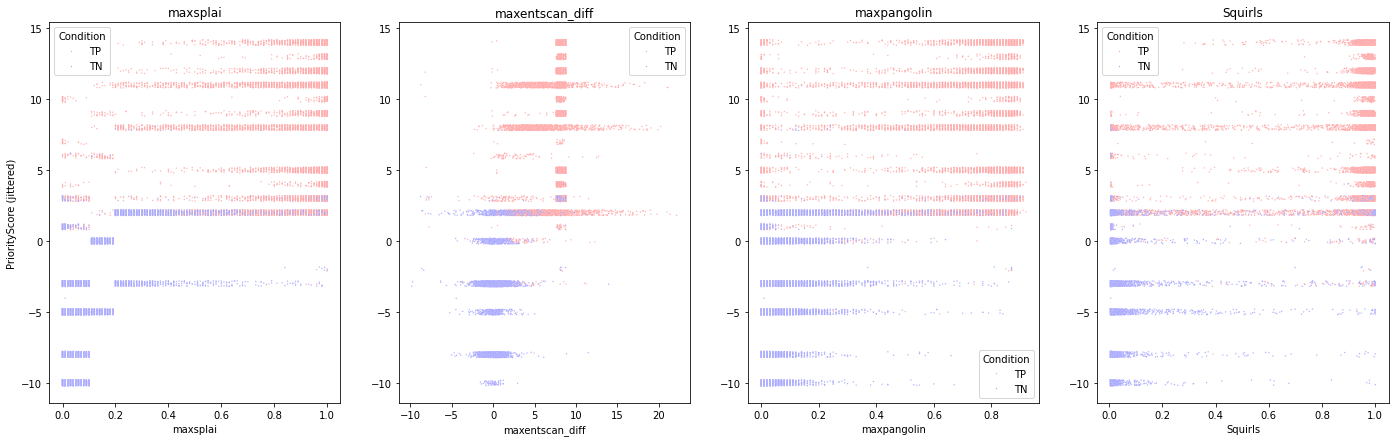

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1, 4, figsize=(24, 7))  # 1行4列のサブプロット
# fig, axes = plt.subplots(2, 2, figsize=(15, 10)) 

colors = {
    'TP': '#ff9999',  # 赤色
    'TN': '#9999ff',  # 青色
}


data = df_test.copy()
# data = data[['LABEL', 'PriorityScore', 'maxsplai']]
data['PriorityScore'] = data['PriorityScore'].astype(int)
data['maxsplai'] = data['maxsplai'].astype(float)

# PriorityScore に jitter（乱数で少しずらす）を加える
jitter_amount = 0.2  # jitter の幅（必要に応じて調整してください）
data['PriorityScore_jitter'] = data['PriorityScore'] + np.random.uniform(-jitter_amount, jitter_amount, size=len(data))

# 各スコアごとにプロット
scores = ['maxsplai', 'maxentscan_diff', 'maxpangolin', 'Squirls']
thresholds = [0.1, float(thr_maxent), float(thr_pango), float(thr_squir)]
for i, (ax, score, threshold) in enumerate(zip(axes, scores, thresholds)):
    sns.scatterplot(
        data=data,
        x=score,
        y='PriorityScore_jitter',
        hue='LABEL',
        # style='SpecialCondition',
        palette=colors,
        # markers=markers,
        alpha=0.8,
        s=2,
        ax=ax
    )
    ax.set_title(f'{score}')
    ax.set_xlabel(score)
    ax.set_ylabel('PriorityScore (jittered)')
    ax.legend(title='LABEL')
    if i == 0:  # 一番左のサブプロットにだけy軸ラベルを表示
        ax.set_ylabel('PriorityScore (jittered)')
    else:
        ax.set_ylabel('')  # 他のサブプロットではy軸ラベルを非表示
    ax.legend(title='Condition')

In [21]:
"""
PriorityScore偽陰性の検出
maxsplai >= 0.2 かつ MaxEntScan_abs >= 2.3 かつ Pangolin >= 0.2 かつ Squirls >= 0.04 かつ
LABEL = 1 かつ PriorityScore < 1.0
"""
# fp = df_test[(df_test['PriorityScore'] < 1) & (df_test['LABEL'] == "TP") & (df_test['maxsplai'] > 0.2)]
fp = df_test[(df_test['PriorityScore'] < 1) & (df_test['LABEL'] == "TP") & (df_test['maxsplai'] > 0.2) & (df_test['maxentscan_diff_abs'] >= 2.3) & (df_test['maxpangolin'] >= 0.2) & (df_test['Squirls'] >= 0.04)]
# fp[['CHROM', 'POS', 'REF', 'ALT', 'GeneSymbol','is_Canonical', 'maxsplai', 'maxpangolin', 'clinvar_clnsig','LABEL','Part_ExDel','insilico_screening','clinvar_screening', 'recalibrated_splai', 'PriorityScore']]
fp.to_excel('false_negatives.xlsx', index=False)

In [17]:
"""
SpliceAI偽陰性の検出
maxsplai < 0.2 かつ MaxEntScan < 2.3 かつ Pangolin < 0.2 かつ Squirls < 0.04 かつ
LABEL = 1 かつ PriorityScore > 1.0
"""
fw_only_positive = df_test[(df_test['maxsplai'] < 0.2) & (df_test['maxentscan_diff'] < 2.3) & (df_test['maxpangolin'] < 0.2) & (df_test['Squirls'] < 0.04) & (df_test['LABEL'] == "TP") & (df_test['PriorityScore'] > 1.0)]
fw_only_positive[['CHROM', 'POS', 'REF', 'ALT', 'GeneSymbol','is_Canonical', 'maxsplai', 'maxpangolin', 'clinvar_clnsig','LABEL','Part_ExDel','insilico_screening','clinvar_screening', 'recalibrated_splai', 'PriorityScore']]
fw_only_positive.to_excel('fw_only_positive.xlsx')

In [17]:
df_test.columns

Index(['CHROM', 'POS', 'REF', 'ALT', 'GeneSymbol', 'SymbolSource', 'HGNC_ID',
       'ENST', 'HGVSc', 'Consequence', 'EXON', 'INTRON', 'Strand', 'DS_AG',
       'DS_AL', 'DS_DG', 'DS_DL', 'DP_AG', 'DP_AL', 'DP_DG', 'DP_DL',
       'maxsplai', 'loftee', 'maxentscan_alt', 'maxentscan_diff',
       'maxentscan_ref', 'pang_gene', 'pang_pos_socre_gain',
       'pang_pos_score_loss', 'pang_warning', 'maxpangolin', 'Squirls',
       'ENST_Full', 'IntronDist', 'is_Canonical', 'Ex_or_Int', 'ex_up_dist',
       'ex_down_dist', 'exon_pos', 'prc_exon_loc', 'exon_splice_site',
       'SpliceType', 'clinvar_same_pos', 'clinvar_same_motif',
       'same_motif_clinsigs', 'ExInt_INFO', 'Pseudoexon', 'Part_IntRet',
       'Part_ExDel', 'Exon_skipping', 'Int_Retention', 'multiexs',
       'Size_Part_ExDel', 'Size_Part_IntRet', 'Size_pseudoexon', 'Size_IntRet',
       'Size_skipped_exon', 'variant_id', 'CDS_Length', 'is_10%_truncation',
       'is_eLoF', 'is_NMD_at_Canon', 'is_Frameshift_Part_ExDel',
    

In [ ]:
df = df_test

# Plot distribtuion of PriorityScore and maxsplai using scatter plot
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()

# Add traces
# Add horizontal line at y = 1.0
fig.add_trace(go.Scatter(
	x=[-0.1, 1.1], y=[1, 1], mode='lines', name='Threshold', 
	line=dict(color='gray', width=2, dash='dash'), showlegend=False)
	)

# Add horizontal line at x = 0.1
fig.add_trace(go.Scatter(
	x=[0.1, 0.1], y=[-10, 15], mode='lines', name='Threshold',
	line=dict(color='gray', width=2, dash='dash'), showlegend=False)
	)

# LABEL = 1 (TP) is red, LABEL = 0 is blue (TN)
# x axis is SpliceAI, y axis is PriorityScore
# Using box plot and scatter plot
fig.add_trace(go.Scatter(
	x=df[df['LABEL'] == 1]['maxsplai'], y=df[df['LABEL'] == 1]['PriorityScore'], 
	mode='markers', name='TP', marker=dict(color='red', size=5), opacity=0.6)
	)

fig.add_trace(go.Scatter(
	x=df[df['LABEL'] == 0]['maxsplai'], y=df[df['LABEL'] == 0]['PriorityScore'], 
	mode='markers', name='TN', marker=dict(color='blue', size=5), opacity=0.6)
	)


# Add titles and labels
fig.update_layout(title='Framework vs. SpliceAI',
				  yaxis_title='PriorityScore',
				  xaxis_title='SpliceAI',
				  plot_bgcolor='rgba(243, 243, 243, 1)',
				  paper_bgcolor='rgba(255, 255, 255, 1)',
				  margin=dict(l=40, r=40, t=40, b=40))

# fig.update_xaxes(range=[-10.05, 15.05])
# fig.update_yaxes(range=[-0.05, 1.05])

fig.update_yaxes(range=[-10.5, 15.05])
fig.update_xaxes(range=[-0.05, 1.05])


# Add anotation for a horizontal line at y = 1.0 (Optimal threshold for PriorityScore)
fig.add_annotation(x=1.0, y=0.42, xref="paper", yref="paper",
				   text=f"Optimal threshold for PriorityScore",
				   showarrow=False,
				   font=dict(family="Arial, sans-serif", size=12, color="black"),
				   bgcolor='rgba(243, 243, 243, 1)',
				#    bordercolor="black",
				   borderwidth=2)

fig.add_annotation(x=0.001, y=0.97, xref="paper", yref="paper",
				   text=f"SpliceAI < 0.1",
				   showarrow=False,
				   font=dict(family="Arial, sans-serif", size=12, color="black"),
				   bgcolor='rgba(243, 243, 243, 1)',
				#    bordercolor="black",
				   borderwidth=2)

# Set figure size
fig.update_layout(width=900, height=500)

# Save as html
# fig.write_html("figs/insilico-tools.html")

# Show figure
fig.show()

<Figure size 2160x2160 with 0 Axes>

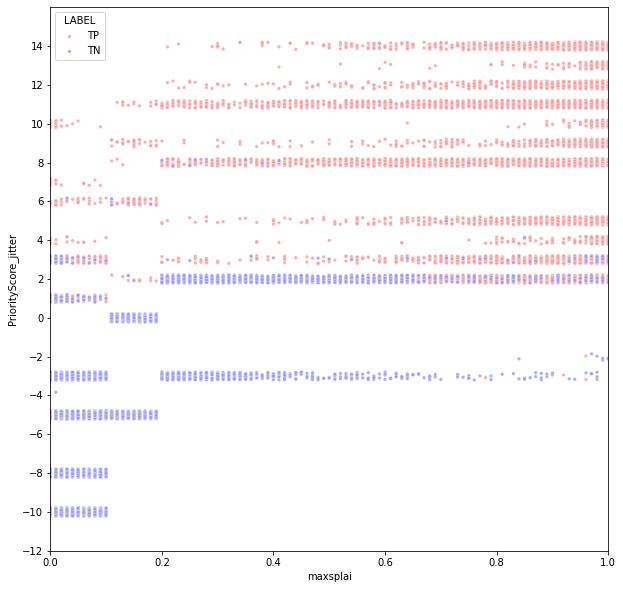

In [ ]:
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# テスト用データのサンプリング
data = df_test.copy()
# data = data[['LABEL', 'PriorityScore', 'maxsplai']]
data['PriorityScore'] = data['PriorityScore'].astype(int)
data['maxsplai'] = data['maxsplai'].astype(float)

# PriorityScore に jitter（乱数で少しずらす）を加える
jitter_amount = 0.2  # jitter の幅（必要に応じて調整してください）
data['PriorityScore_jitter'] = data['PriorityScore'] + np.random.uniform(-jitter_amount, jitter_amount, size=len(data))

# 図のサイズ設定
plt.figure(figsize=(30, 30))
fig, ax = plt.subplots(1,1, figsize=(10, 10))

# scatterplot の作成（y 軸に jitter を加えた値を利用）
colors = {
    'TP': '#ff9999',  # 赤色
    'TN': '#9999ff',  # 青色
}

# scatterplot の作成
sns.scatterplot(
    data=data,
    x='maxsplai',
    y='PriorityScore_jitter',
    hue='LABEL',
    palette=colors,  # カスタムカラーパレットの使用
    alpha=0.8,
    s=12  # マーカーサイズ
)

# x, y 軸の表示範囲を設定
plt.xlim(0, 1)      # maxsplai の範囲 0〜1
plt.ylim(-12, 16)   # PriorityScore の表示範囲

# y 軸の目盛り間隔を2単位ごとに設定（他の値に変更可能です）
# ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
# もしくは以下のように直接リストを指定する方法もあります：
plt.yticks(np.arange(-12, 16, 2))

plt.show()


In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # 1行4列のサブプロット

# 各スコアごとにプロット
scores = ['maxsplai', 'maxentscan_diff', 'maxpangolin', 'Squirls']
for ax, score in zip(axes, scores):
    sns.scatterplot(
        data=data,
        x=score,
        y='PriorityScore_jitter',
        hue='SpecialCondition',
        style='SpecialCondition',
        palette=colors,
        # markers=markers,
        alpha=0.6,
        s=100,
        ax=ax
    )
    ax.set_title(f'Scatterplot for {score}')
    ax.set_xlabel(score)
    ax.set_ylabel('PriorityScore (jittered)')
    ax.legend(title='Condition')

##### 6. Bootstrap

In [13]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score, matthews_corrcoef, f1_score
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

def multiple_imputation_dataframes(
        df, feature_cols, n_imputations=5, random_state=12, max_iter=10):
    """
    df のうち feature_cols に含まれる列を対象に、
    IterativeImputer を使って M 回の多重代入を行う。
    
    Parameters
    ----------
    df : pd.DataFrame
        オリジナルのデータフレーム（欠損を含む）
    feature_cols : list
        補完対象の特徴量カラム名
    n_imputations : int
        何回多重代入を行うか
    random_state : int
        乱数シードの初期値
    max_iter : int
        IterativeImputer の繰り返し回数
    
    Returns
    -------
    imputed_dfs : list of pd.DataFrame
        多重代入後の DataFrame を要素とするリスト（長さ n_imputations）
    """
    
    # df はそのままにして、参照部分だけコピー
    df_original = df.copy()
    
    # 結果を格納するリスト
    imputed_dfs = []
    
    for i in range(n_imputations):
        # 例として、iterationごとにシードを変える
        rs = random_state + i
        
        # IterativeImputer のインスタンスを作成
        imputer = IterativeImputer(
            max_iter=max_iter,
            random_state=rs,
            sample_posterior=True  # 多重代入の雰囲気を出すために True にしてみる
        )
        
        # 補完対象の部分を fit_transform
        X_imputed = imputer.fit_transform(df_original[feature_cols])
        
        # 元の DataFrame に埋め戻す
        df_imputed = df_original.copy()
        df_imputed[feature_cols] = X_imputed

        # 補完された値を元に、判定を追加 ("pred_maxent"列と"pred_squirls"列)
        df_imputed["pred_maxent"] = df_imputed.apply(
            add_pred_col, args=('maxentscan_diff', float(thr_maxent)), axis=1)
        df_imputed["pred_squirls"] = df_imputed.apply(
            add_pred_col, args=('Squirls', float(thr_squir)), axis=1)
        
        # 補完と判定結果を追記したpd.DataFrameをリストに追加
        imputed_dfs.append(df_imputed)
    
    return imputed_dfs


def simple_rubins_rules(theta_list):
    """
    Rubin's Rules に基づいて、補完後のデータから得られた統計量などを統合し、
    最終的な推定値 (mean) を返す. 分散は計算しない. 

    Parameters
    ----------
    theta_list : array-like of float
        各イミュテーションで得られた推定量 (length=M)
    
    Returns
    -------
    theta_bar : float
        多重代入後の推定量 (Rubinの平均推定)
    """
    return np.mean(theta_list)

def specificity_score(y_true, y_pred):
    tn, fp, _, _ = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def calc_metrics(y_true, y_pred,) -> tuple:
    auroc = roc_auc_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred)
    specificity = specificity_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return auroc, precision, recall, specificity, accuracy, mcc, f1


##### 時間かかる - 各metricsを2000回計算する

グラフ作成 bootstrap resultsの読み込み

In [22]:
ps_1_results = pd.read_pickle('bootstrap_results/B2000_ps_1_results.pkl')
splai_02_results = pd.read_pickle('bootstrap_results/B2000_splai_02_results.pkl')
splai_05_results = pd.read_pickle('bootstrap_results/B2000_splai_05_results.pkl')
splai_08_results = pd.read_pickle('bootstrap_results/B2000_splai_08_results.pkl')
maxent_results = pd.read_pickle('bootstrap_results/B2000_maxent_results.pkl')
pangolin_results = pd.read_pickle('bootstrap_results/B2000_pangolin_results.pkl')
squirls_results = pd.read_pickle('bootstrap_results/B2000_squirls_results.pkl')

def rename_cols(df: pd.DataFrame, prefix: str) -> pd.DataFrame:
    return df.rename(columns={
        "auroc": f"{prefix}_auroc", "precision": f"{prefix}_precision",
        "recall": f"{prefix}_recall", "specificity": f"{prefix}_specificity",
        "accuracy": f"{prefix}_accuracy", "mcc": f"{prefix}_MCC", "f1": f"{prefix}_F1-score"})

ps_1_results = rename_cols(ps_1_results, 'PriorityScore_1')
splai_02_results = rename_cols(splai_02_results, 'SpliceAI_02')
splai_05_results = rename_cols(splai_05_results, 'SpliceAI_05')
splai_08_results = rename_cols(splai_08_results, 'SpliceAI_08')
maxent_results = rename_cols(maxent_results, 'MaxEntScan')
pangolin_results = rename_cols(pangolin_results, 'Pangolin')
squirls_results = rename_cols(squirls_results, 'Squirls')

# Horizontal concatenation
boot_results = pd.concat([ps_1_results, splai_02_results, splai_05_results, splai_08_results, maxent_results, pangolin_results, squirls_results], axis=1)
print(f"results.shape: {boot_results.shape}")

results.shape: (2000, 49)


In [24]:
ps_1_results = pd.read_pickle('bootstrap_results/B2000_ps_1_results.pkl')
splai_02_results = pd.read_pickle('bootstrap_results/B2000_splai_02_results.pkl')
splai_05_results = pd.read_pickle('bootstrap_results/B2000_splai_05_results.pkl')
splai_08_results = pd.read_pickle('bootstrap_results/B2000_splai_08_results.pkl')
maxent_results = pd.read_pickle('bootstrap_results/B2000_maxent_results.pkl')
pangolin_results = pd.read_pickle('bootstrap_results/B2000_pangolin_results.pkl')
squirls_results = pd.read_pickle('bootstrap_results/B2000_squirls_results.pkl')

def rename_cols(df: pd.DataFrame, prefix: str) -> pd.DataFrame:
    return df.rename(columns={
        "auroc": f"{prefix}_auroc", "precision": f"{prefix}_precision",
        "recall": f"{prefix}_recall", "specificity": f"{prefix}_specificity",
        "accuracy": f"{prefix}_accuracy", "mcc": f"{prefix}_MCC", "f1": f"{prefix}_F1-score"})

ps_1_results = rename_cols(ps_1_results, 'PriorityScore_1')
splai_02_results = rename_cols(splai_02_results, 'SpliceAI_02')
splai_05_results = rename_cols(splai_05_results, 'SpliceAI_05')
splai_08_results = rename_cols(splai_08_results, 'SpliceAI_08')
maxent_results = rename_cols(maxent_results, 'MaxEntScan')
pangolin_results = rename_cols(pangolin_results, 'Pangolin')
squirls_results = rename_cols(squirls_results, 'Squirls')

In [32]:
nonimp_with_ci = pd.read_pickle("/Users/utsu/work/Github/nar/ValidationData/TP/additional/bootstrap_results/B2000_final_results_with_BCA_CI_nonimp.pkl")
maxentscan_with_ci = pd.read_pickle("/Users/utsu/work/Github/nar/ValidationData/TP/additional/bootstrap_results/B2000_final_results_with_BCA_CI_maxentscan_abs.pkl")
squirls_with_ci = pd.read_pickle("/Users/utsu/work/Github/nar/ValidationData/TP/additional/bootstrap_results/B2000_final_results_with_BCA_CI_squirls.pkl")

# concatenate above three DataFrames without rename_col


In [36]:
with_ci = pd.concat([nonimp_with_ci, maxentscan_with_ci, squirls_with_ci], axis=0)

with_ci.to_excel('excel/B2000_final_results_with_BCA_CI_abs.xlsx', index=False)

,Category,mean,lower,upper
0,PriorityScore_1_auroc,0.973095,0.970153,0.976195
1,PriorityScore_1_precision,0.898549,0.888652,0.908395
2,PriorityScore_1_recall,0.972450,0.967011,0.977819
3,PriorityScore_1_specificity,0.973739,0.971065,0.976385
4,PriorityScore_1_accuracy,0.973490,0.971150,0.975911
5,PriorityScore_1_MCC,0.918604,0.911504,0.925879
6,PriorityScore_1_F1-score,0.934032,0.928175,0.940192
7,SpliceAI_02_auroc,0.957711,0.953859,0.961710
8,SpliceAI_02_precision,0.875835,0.865658,0.886471
9,SpliceAI_02_recall,0.947551,0.940380,0.955113


##### 各metricsの比較

In [16]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# metrics の定義
metrics = ["precision", "recall", "specificity", "accuracy", "MCC", "F1-score"]

# サブプロットを作成: 2行×3列 = 6プロット
rows = 2
cols = 3
fig = make_subplots(
    rows=rows,
    cols=cols,
    subplot_titles=metrics,          # 各サブプロット上部に指標名をタイトル表示
    horizontal_spacing=0.05,        # サブプロット間の左右余白
    vertical_spacing=0.1          # サブプロット間の上下余白を調整
)

for i, metric in enumerate(metrics):
    # --- 該当する列の抽出 ---
    target_cols = [col for col in boot_results.columns if col.endswith(f"_{metric}")]
    
    method_values = {}
    for col in target_cols:
        # 末尾の "_<metric>" を削除した部分を「メソッド名」とみなす
        method_name = col[:-len(metric)-1] 
        method_values[method_name] = boot_results[col].mean()
    
    # プロット用 DataFrame
    plot_df = pd.DataFrame({
        'method': list(method_values.keys()),
        'value': list(method_values.values())
    })

    # 最大値を取得
    max_val = plot_df['value'].max()
    
    # 最大値を持つメソッドを特定し、色リストを作成
    colors = ['maroon' if val == max_val else 'navy' for val in plot_df['value']]
    
    # 行、列を計算
    row_idx = i // cols + 1  # 2行×3列に配置
    col_idx = i % cols + 1

    # --- go.Bar でトレースを作り、サブプロットに追加 ---
    fig.add_trace(
        go.Bar(
            x=plot_df['method'],
            y=plot_df['value'],
            marker_color=colors,  # 最大値のバーを赤色に、それ以外を青色に設定
            text=[f"{v:.3f}" for v in plot_df['value']],  # 数値ラベルを追加
            textposition='auto',  # ラベルを最適な位置に自動配置
            textfont=dict(
                size=10,            # フォントサイズを小さく
                color='white'       # 数値ラベルの色を白に設定
            ),
            width=0.6,             # バーの幅を調整（必要に応じて変更）
            cliponaxis=False       # ラベルが切れないように設定
        ),
        row=row_idx,
        col=col_idx
    )

    # x軸, y軸のラベル設定
    # サブプロットの1行目の場合、x軸ラベルを非表示に設定
    if row_idx == 1:
        fig.update_xaxes(
            title_text="",            # x軸タイトルを非表示
            showticklabels=False,    # x軸の目盛りラベルを非表示
            row=row_idx, 
            col=col_idx, 
            tickangle=90,            # x軸ラベルを90度回転（必要なら保持）
            tickfont=dict(size=10)   # x軸ラベルのフォントサイズを調整（非表示なので影響なし）
        )
    else:
        # 2行目のサブプロットはx軸ラベルを表示
        fig.update_xaxes(
            title_text="Method", 
            row=row_idx, 
            col=col_idx, 
            tickangle=270,           # x軸ラベルを90度回転
            tickfont=dict(size=10)  # x軸ラベルのフォントサイズを調整
        )
    
    # y軸のラベル設定（常に表示）
    fig.update_yaxes(
        title_text=metric.capitalize(), 
        row=row_idx, 
        col=col_idx, 
        range=[0, 1.05],
        tickfont=dict(size=14)  # y軸ラベルのフォントサイズを調整
    )

# レイアウト調整
fig.update_layout(
    bargap=0.1,        # バー間の隙間
    bargroupgap=0.0,   # グループ間の隙間
    width=1600,        # 幅を1800から2000に拡大
    height=800,       # 高さを900から1000に拡大
    showlegend=False,  # 全体のレジェンドを消す(必要ならTrueに)
    plot_bgcolor='rgba(243, 243, 243, 1)',
    paper_bgcolor='rgba(255, 255, 255, 1)',
    margin=dict(l=70, r=70, t=80, b=40)  # マージンを更に増やしてラベルのスペースを確保
)

fig.show()


NameError: name 'boot_results' is not defined

In [ ]:
# T0作る, imputationあり
df_test = pd.read_pickle('train_test_pkls/df_test_for_bootstrap.pkl')

feature_cols = ["PriorityScore", "maxsplai", "maxpangolin", "maxentscan_diff", "Squirls"]

# imputed_dfsを作る．多重代入の回数は5回．
imputed_dfs, pred_col_names = multiple_imputation_dataframes(
    df_test, feature_cols=feature_cols, n_imputations=5, random_state=42, 
    max_iter=10, pred_targets=["maxentscan_diff", "Squirls"], 
    thresholds=[thr_maxent, thr_squir], add_pred_col=add_pred_col)

# 各 imputed_dfs に対して、評価指標を計算 (maxentとsquirlsのみ)

maxent_theta_list_auroc = []
maxent_theta_list_precision = [] 
maxent_theta_list_recall = []
maxent_theta_list_specificity = []
maxent_theta_list_accuracy = []
maxent_theta_list_mcc = []
maxent_theta_list_f1 = []

squirls_theta_list_auroc = []
squirls_theta_list_precision = []
squirls_theta_list_recall = []
squirls_theta_list_specificity = []
squirls_theta_list_accuracy = []
squirls_theta_list_mcc = []
squirls_theta_list_f1 = []

for df_imp in imputed_dfs:
    y_true_imp = df_imp["LABEL"]
    y_score_maxent = df_imp[pred_col_names[0]]
    y_score_squirls = df_imp[pred_col_names[1]]
    
    # Calculate metrics
    maxent_theta_list_auroc.append(roc_auc_score(y_true_imp, y_score_maxent))
    maxent_theta_list_precision.append(precision_score(y_true_imp, y_score_maxent))
    maxent_theta_list_recall.append(recall_score(y_true_imp, y_score_maxent))
    maxent_theta_list_specificity.append(specificity_score(y_true_imp, y_score_maxent))
    maxent_theta_list_accuracy.append(accuracy_score(y_true_imp, y_score_maxent))
    maxent_theta_list_mcc.append(matthews_corrcoef(y_true_imp, y_score_maxent))
    maxent_theta_list_f1.append(f1_score(y_true_imp, y_score_maxent))

    squirls_theta_list_auroc.append(roc_auc_score(y_true_imp, y_score_squirls))
    squirls_theta_list_precision.append(precision_score(y_true_imp, y_score_squirls))
    squirls_theta_list_recall.append(recall_score(y_true_imp, y_score_squirls))
    squirls_theta_list_specificity.append(specificity_score(y_true_imp, y_score_squirls))
    squirls_theta_list_accuracy.append(accuracy_score(y_true_imp, y_score_squirls))
    squirls_theta_list_mcc.append(matthews_corrcoef(y_true_imp, y_score_squirls))
    squirls_theta_list_f1.append(f1_score(y_true_imp, y_score_squirls))
    
# 補完の必要のない分類器は，df_testをそのまま使ってよい
y_true = df_test["LABEL"]
T0_ps_metrics = calc_metrics(y_true, df_test["pred_PS_1"])
T0_splai02_metrics = calc_metrics(y_true, df_test["pred_splai_02"])
T0_splai05_metrics = calc_metrics(y_true, df_test["pred_splai_05"])
T0_splai08_metrics = calc_metrics(y_true, df_test["pred_splai_08"])
T0_pangolin_metrics = calc_metrics(y_true, df_test["pred_pangolin"])

# 補完が必要だった分類器については，Rubin's rule で統合
T0_maxent_metrics = tuple([
    simple_rubins_rules(maxent_theta_list_auroc), simple_rubins_rules(maxent_theta_list_precision), 
    simple_rubins_rules(maxent_theta_list_recall), simple_rubins_rules(maxent_theta_list_specificity),
    simple_rubins_rules(maxent_theta_list_accuracy), simple_rubins_rules(maxent_theta_list_mcc), 
    simple_rubins_rules(maxent_theta_list_f1)])
T0_squirls_metrics = tuple([
    simple_rubins_rules(squirls_theta_list_auroc), simple_rubins_rules(squirls_theta_list_precision),
    simple_rubins_rules(squirls_theta_list_recall), simple_rubins_rules(squirls_theta_list_specificity),
    simple_rubins_rules(squirls_theta_list_accuracy), simple_rubins_rules(squirls_theta_list_mcc),
    simple_rubins_rules(squirls_theta_list_f1)])

T0 = {"PriorityScore_1": T0_ps_metrics, "SpliceAI_02": T0_splai02_metrics, 
      "SpliceAI_05": T0_splai05_metrics, "SpliceAI_08": T0_splai08_metrics, 
      "Pangolin": T0_pangolin_metrics, "MaxEntScan": T0_maxent_metrics, 
      "Squirls": T0_squirls_metrics}

## Debug
print(T0)
boot_results.head()

In [15]:
import numpy as np
import math
from scipy.stats import norm

def _specificity_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    tn, fp, _, _ = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def _calc_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> tuple:
    auroc = roc_auc_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred)
    specificity = _specificity_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return auroc, precision, recall, specificity, accuracy, mcc, f1

def statistic(data: pd.DataFrame, true_col: str, target_col: str) -> tuple:
	y_true: np.ndarray = np.array(data[true_col])
	return _calc_metrics(y_true, data[target_col])

def add_pred_col(row, target_col: str, threshold: float) -> float:
    """
    行ごとに予測列を追加する関数の例
    """
    val = row[target_col]
    if np.isnan(val):
        return np.nan
    elif val >= threshold:
        return 1.0
    else:
        return 0.0

def multiple_imputation_dataframes(
        df: pd.DataFrame, feature_cols: list, n_imputations: int, 
        random_state: int, max_iter: int, pred_targets: list, 
        thresholds: list, add_pred_col) -> tuple:
    """
    df のうち feature_cols に含まれる列を対象に、
    IterativeImputer を使って M 回の多重代入を行う。
    
    Parameters
    ----------
    df : pd.DataFrame
        元データ
    feature_cols : list of str
        補完対象の特徴量カラム名
    n_imputations : int
        何回多重代入を行うか
    random_state : int
        Initial random seed for IterativeImputer
    max_iter : int
        IterativeImputer の繰り返し回数
    pred_targets : list of str
        予測対象のカラム名
    thresholds : list of float
        予測閾値のリスト
    
    Returns
    -------
    imputed_dfs, pred_col_names : list of pd.DataFrame, list of str
        多重代入後の DataFrame を要素とするリスト（長さ n_imputations）
    """
    
    # Initialize list to store imputed DataFrames
    imputed_dfs = []
    
    # Copy original DataFrame
    df_original = df.copy()

    for i in range(n_imputations):
        # Set random_state for IterativeImputer in each iteration
        rs = random_state + i
        
        # IterativeImputer のインスタンスを作成
        imputer = IterativeImputer(
            max_iter=max_iter,
            random_state=rs,
            sample_posterior=True  # 多重代入のために True に設定
        )
        
        # 補完対象の部分を fit_transform
        X_imputed = imputer.fit_transform(df_original[feature_cols])
        
        # 元の DataFrame をコピーして imputed データを埋め戻す
        df_imputed = df_original.copy()
        df_imputed[feature_cols] = X_imputed
        
        # 予測列のカラム名のリストを作成 (pred_col_names)
        pred_col_names = [
            f"pred_{target_col}" for target_col in pred_targets
        ]

        # 補完された値を元に、予測列を追加
        for pred_col_name, target_col, threshold in zip(pred_col_names, pred_targets, thresholds): 
            df_imputed[pred_col_name] = df_imputed.apply(
                lambda row: add_pred_col(row, target_col, threshold),axis=1)
        
        # 補完と予測結果を含む DataFrame をリストに追加
        imputed_dfs.append(df_imputed)

    return imputed_dfs, pred_col_names

def statistic_with_imputation(
          nonimputed_dataframe: pd.DataFrame, 
          n_imputations: int, random_state: int, max_iter: int, 
          true_col: str, feature_cols: list, thresholds: list, 
          pred_targets: list) -> tuple:
    """"
    Parameters
    ----------
    nonimputed_data : pd.DataFrame
        欠損値を含むデータフレーム
    feature_cols : list
        補完対象の特徴量カラム名
    n_imputation : int
        何回多重代入を行うか
    random_state : int
        乱数シードの初期値
    max_iter : int
        IterativeImputer の繰り返し回数
    true_col : str
        正解ラベルのカラム名
    thresholds : list
        予測閾値のリスト
    pred_targets : list
        予測対象のカラム名

    Returns
    -------
    results : tuple
        Rubin's rule で統合した結果 
        {str: (float, float, float, float, float, float, float)}, list
    """
    # Initialize list to return
    results = {}

    imputed_dfs, pred_col_names = multiple_imputation_dataframes(
        df=nonimputed_dataframe, feature_cols=feature_cols,
        n_imputations=n_imputations, random_state=random_state, 
        max_iter=max_iter, thresholds=thresholds, add_pred_col=add_pred_col, 
        pred_targets=pred_targets
        )
    
    # Initialize lists to store metrics
    for pred_col_name in pred_col_names:
        # Initialize lists to store metrics (list of lists)
        theta_lists: list = [ [] for _ in range(7) ]

        # Set each list to variables
        theta_list_auroc, theta_list_precision, \
        theta_list_recall, theta_list_specificity, \
        theta_list_accuracy, theta_list_mcc, theta_list_f1 = theta_lists

        for imputed_df in imputed_dfs:
            y_true_imp: np.ndarray = np.array(imputed_df[true_col])
            y_score_pred_col: np.ndarray = np.array(imputed_df[pred_col_name])
            theta_list_auroc.append(roc_auc_score(y_true_imp, y_score_pred_col))
            theta_list_precision.append(precision_score(y_true_imp, y_score_pred_col))
            theta_list_recall.append(recall_score(y_true_imp, y_score_pred_col))
            theta_list_specificity.append(_specificity_score(y_true_imp, y_score_pred_col))
            theta_list_accuracy.append(accuracy_score(y_true_imp, y_score_pred_col))
            theta_list_mcc.append(matthews_corrcoef(y_true_imp, y_score_pred_col))
            theta_list_f1.append(f1_score(y_true_imp, y_score_pred_col))

        # Integrate results using Rubin's rule
        tmp_tuple = tuple(
            [simple_rubins_rules(theta_list) for theta_list in theta_lists]
            )
        
        results.update({pred_col_name: tmp_tuple})
    
    return results, pred_col_names

def calc_z0(T0: dict, boot_results: pd.DataFrame) -> dict:
    """
    Calculate z0 value
    """
    results = {}
    metrics_list = ["auroc", "precision", "recall", "specificity", "accuracy", "MCC", "F1-score"]

    # T0について分解する. T0は単純な辞書
    for target_method, T0_metrics in T0.items():
        for T0_metric_valeue, metric in zip(T0_metrics, metrics_list):
        # boot_resultsを列ごとに分解する（このforは各統計量で回している）
            boot_metric_array: np.ndarray = np.array(boot_results[f"{target_method}_{metric}"])
            
            p = np.mean(boot_metric_array < T0_metric_valeue)
            if p <= 0:
                p = 1e-15
            if p >= 1:
                p = 1 - 1e-15
            z0 = norm.ppf(p)
            
            results.update({f"{target_method}_{metric}": z0})
    
    return results

def calc_metrics_with_jack_knife(
        original_df: pd.DataFrame, true_col: str, target_cols: list, 
        missing_cols: list, ths_dict: dict) -> dict:
    """
    Calculate metrics with jackknife method
    """
    n = len(original_df)
    T_jack = {}

    print("Start calculating metrics with jackknife method")
    iter_cols = target_cols + missing_cols  
    for col in iter_cols:
        results = []

        print(f"\nCalculating metrics for {col}")
        for i in tqdm(range(n)):
            jack_df: pd.DataFrame = original_df.drop(i)

            if col in target_cols:
                jack_metrics: tuple = statistic(jack_df, true_col, col)
                results.append(jack_metrics)
                T_jack.update({col: results})
            elif col in missing_cols:
                jack_metrics, pred_col_names = statistic_with_imputation(
                    jack_df, n_imputations=5, random_state=42, max_iter=10, 
                    true_col=true_col, feature_cols=feature_cols, 
                    thresholds=[ths_dict[col]], pred_targets=[col])
                results.append(jack_metrics[pred_col_names[0]])
                T_jack.update({pred_col_names[0]: results})
            else:
                raise ValueError(f"Invalid column name: {col}")
            
    return T_jack


def calc_acceleration_factor(
        T_jack: np.ndarray, original_data_length: int) -> dict:
    """
    Calculate acceleration factor for each column
    """
    n = original_data_length
    T_dot = np.mean(T_jack)
    numerator = np.sum((T_jack - T_dot) ** 3)
    denominator = 6 * np.sum((T_jack - T_dot) ** 2) ** 1.5
    
    # Avoid infinite acceleration
    if denominator == 0:
        a = 0.0
    else:
        a = numerator / denominator
    
    return a


In [ ]:
results, _ = statistic_with_imputation(
    nonimputed_dataframe=df_test, n_imputations=5, random_state=42, max_iter=10, 
    true_col="LABEL", feature_cols=feature_cols, 
    thresholds=[thr_maxent, thr_squir], pred_targets=["maxentscan_diff", "Squirls"])

ths_dict = {"maxentscan_diff": thr_maxent, "Squirls": thr_squir}
target_cols = []
missing_cols = []
# target_cols = ["pred_PS_1", "pred_splai_02", "pred_splai_05", "pred_splai_08", "pred_pangolin"]
# target_cols = ["pred_PS_1", "pred_splai_02", "pred_splai_05", "pred_splai_08", "pred_pangolin"]
# missing_cols = ["maxentscan_diff", "Squirls"]
missing_cols = ["maxentscan_diff"]

t_jack: dict = calc_metrics_with_jack_knife(
    original_df=df_test, true_col="LABEL", target_cols=target_cols, 
    missing_cols=missing_cols, ths_dict=ths_dict)

acceleration_factors: dict = {}

for key, target_method in zip(t_jack.keys(), T0.keys()):
    t_jack_valuelist = np.array(t_jack[key])
    transposed_t_jack = t_jack_valuelist.T
    t_jack_aurocs, t_jack_precisions, t_jack_recalls, t_jack_specificities, t_jack_accuracies, t_jack_mccs, t_jack_f1s = transposed_t_jack.tolist()
    
    t_jacks_metric = [t_jack_aurocs, t_jack_precisions, t_jack_recalls, t_jack_specificities, t_jack_accuracies, t_jack_mccs, t_jack_f1s]
    metrics_list = ["auroc", "precision", "recall", "specificity", "accuracy", "MCC", "F1-score"]

    for t_jack_metric, metric in zip(t_jacks_metric, metrics_list):
        a = calc_acceleration_factor(np.array(t_jack_metric), len(df_test))
        acceleration_factors.update({f"{target_method}_{metric}": a})

final_results = {}
alpha = 0.05
z0s = calc_z0(T0, boot_results)

alpha_lower: float = alpha / 2.0
alpha_upper: float = 1 - alpha_lower    # i.e. 1-alpha/2

z_lower = norm.ppf(alpha_lower)  # z_{α/2} 標準正規分布の下側 α/2 点
z_upper = norm.ppf(alpha_upper)  # z_{1-α/2} 標準正規分布の上側 1-α/2 点

for a, z0, key in zip(acceleration_factors.values(), z0s.values(), z0s.keys()):
 
    # 新しいz値
    adj_lower = z0 + (z0 + z_lower) / (1.0 - a * (z0 + z_lower))
    adj_upper = z0 + (z0 + z_upper) / (1.0 - a * (z0 + z_upper))

    # それぞれのz値に対応する累積分布関数からわかる累積確率
    alpha_bca_lower = norm.cdf(adj_lower)
    alpha_bca_upper = norm.cdf(adj_upper)

    alpha_bca_lower = max(min(alpha_bca_lower, 1.0), 0.0)
    alpha_bca_upper = max(min(alpha_bca_upper, 1.0), 0.0)

    lower = np.quantile(boot_results[key], alpha_bca_lower)
    upper = np.quantile(boot_results[key], alpha_bca_upper)

    final_results.update({key: (boot_results[key].mean(), lower, upper)})
    print(f"{key}: {boot_results[key].mean()} ({lower}, {upper})")

# To pd.DataFrame
final_results_df = pd.DataFrame(final_results).T
final_results_df = final_results_df.reset_index()
final_results_df = final_results_df.rename(columns={"index": "Category", 0: "mean", 1: "lower", 2: "upper"})

# Save as pickle
pkl_name = "bootstrap_results/B2000_final_results_with_BCA_CI_maxentscan.pkl"
final_results_df.to_pickle(pkl_name)

In [70]:
plot_df

,method,value
0,PriorityScore_1,0.934032
1,SpliceAI_02,0.910271
2,SpliceAI_05,0.929662
3,SpliceAI_08,0.863954
4,MaxEntScan,0.743287
5,Pangolin,0.901100
6,Squirls,0.929459


In [69]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 表示したい指標を絞り込み
metrics_of_interest = ["recall", "specificity", "MCC", "F1-score"]

# 横一列に並べるために、1行×(指標の数)列を指定
rows = 1
cols = len(metrics_of_interest)

# サブプロットを作成
fig = make_subplots(
    rows=rows,
    cols=cols,
    subplot_titles=metrics_of_interest,   # 各サブプロット上部に指標名をタイトル表示
    horizontal_spacing=0.05,             # サブプロット間の左右余白
    vertical_spacing=0.1                 # サブプロット間の上下余白(1行なのであまり影響なし)
)

for i, metric in enumerate(metrics_of_interest):
    # 今回プロットしたい列のみ抽出: 例 "SpliceAI_02_recall", "Pangolin_recall" 等
    target_cols = [col for col in boot_results.columns if col.endswith(f"_{metric}")]
    
    method_values = {}
    for col in target_cols:
        # 末尾の "_<metric>" を削除してメソッド名を得る
        # 例: "SpliceAI_02_recall" -> メソッド名: "SpliceAI_02"
        method_name = col[:-len(metric)-1]
        method_values[method_name] = boot_results[col].mean()  # 平均値などを取得

    # プロット用に整形
    plot_df = pd.DataFrame({
        'method': list(method_values.keys()),
        'value': list(method_values.values())
    })

    # 最大値の取得
    max_val = plot_df['value'].max()
    
    # バーの色を分ける (最大値 = maroon、それ以外 = navy)
    colors = ['maroon' if val == max_val else 'navy' for val in plot_df['value']]
    
    # サブプロット内の行列位置を算出
    # 今回は1行なので row=1, 列は i+1
    row_idx = 1
    col_idx = i + 1
    
    # 横向きバー (orientation='h')
    fig.add_trace(
        go.Bar(
            x=plot_df['value'],
            y=plot_df['method'],
            orientation='h',         # 横向きのバー
            marker_color=colors,     
            text=[f"{v:.3f}" for v in plot_df['value']],  # 数値ラベル(小数点第3位)
            textposition='auto',                        
            textfont=dict(
                size=10,
                color='white'
            ),
            width=0.6,        # バーの太さを調整
            cliponaxis=False  # ラベルがはみ出さないよう設定
        ),
        row=row_idx,
        col=col_idx
    )
    
    # x軸 (今回の値軸) は 0～1.05 の範囲に設定（必要に応じて調整）
    fig.update_xaxes(
        title_text=metric.capitalize(),   # x軸タイトルをメトリクス名に
        range=[0, 1.05],
        tickfont=dict(size=10),
        row=row_idx,
        col=col_idx
    )

    # y軸 (メソッド名) の設定: 一番左(col_idx==1)だけラベルや目盛りを表示、それ以外は非表示
    if col_idx == 1:
        # 左端のサブプロットのみメソッド名を表示
        fig.update_yaxes(
            title_text="Method",
            showticklabels=True,
            tickfont=dict(size=10),
            row=row_idx,
            col=col_idx
        )
    else:
        # それ以外のサブプロットはメソッド名を非表示
        fig.update_yaxes(
            title_text="",        # y軸タイトルを空に
            showticklabels=False, # メソッドの軸ラベル(目盛り)も非表示
            tickfont=dict(size=10),
            row=row_idx,
            col=col_idx
        )

# レイアウト調整
fig.update_layout(
    bargap=0.1,        
    bargroupgap=0.0,   
    width=1300,        # 横幅を調整
    height=600,        # 縦幅を調整
    showlegend=False,  
    plot_bgcolor='rgba(243, 243, 243, 1)',
    paper_bgcolor='rgba(255, 255, 255, 1)',
    margin=dict(l=70, r=70, t=80, b=40)
)

fig.show()


In [20]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 表示したい指標
metrics_of_interest = ["recall", "specificity", "Mcc", "F1-score"]

# x軸ラベル修正用のマッピング（例："Mcc" → "MCC", "F1-score" → "F1-Score"）
metric_mapping = {
    "mcc": "MCC",
    "f1-score": "F1-Score"
}

# y軸（メソッド名）修正用のマッピング
method_mapping = {
    "PriorityScore_1": "Priority Score",
    "SpliceAI_02": "SpliceAI (0.2)",
    "SpliceAI_05": "SpliceAI (0.5)",
    "SpliceAI_08": "SpliceAI (0.8)",
    "MaxEntScan": "MaxEntScan",
    "Pangolin": "Pangolin"
}

rows = 1
cols = len(metrics_of_interest)

# subplot_titles を指定しないので、上部ラベルは表示されません。
# horizontal_spacing の値を調整することで横方向の間隔を変更できます。
fig = make_subplots(
    rows=rows,
    cols=cols,
    horizontal_spacing=0.025,  # ここで間隔を調整
    vertical_spacing=0.1
)

for i, metric in enumerate(metrics_of_interest):
    # 対象のカラム抽出（大文字小文字を区別せずに検索）
    target_cols = [col for col in boot_results.columns if col.lower().endswith(f"_{metric.lower()}")]
    
    method_values = {}
    for col in target_cols:
        # 末尾の "_<metric>" を除いてメソッド名を取得
        method_name = col[:-len(metric)-1]
        # マッピングがあれば置換、なければそのまま使用
        display_name = method_mapping.get(method_name, method_name)
        method_values[display_name] = boot_results[col].mean()
    
    # プロット用のDataFrame作成
    plot_df = pd.DataFrame({
        'method': list(method_values.keys()),
        'value': list(method_values.values())
    })
    
    max_val = plot_df['value'].max()
    # 最大値は "#800000"（maroon）、それ以外は "#000080"（navy）で色分け
    colors = ['#CC5500' if val == max_val else '#008080' for val in plot_df['value']]
    
    row_idx = 1
    col_idx = i + 1
    
    fig.add_trace(
        go.Bar(
            x=plot_df['value'],
            y=plot_df['method'],
            orientation='h',
            marker_color=colors,
            text=[f"{v:.3f}" for v in plot_df['value']],
            textposition='auto',
            textfont=dict(size=12, color="#FFFFFF"),
            width=0.6,
            cliponaxis=False
        ),
        row=row_idx,
        col=col_idx
    )
    
    # x軸ラベルは "Mcc" → "MCC" などに変換
    x_axis_label = metric_mapping.get(metric.lower(), metric.capitalize())
    
    fig.update_xaxes(
        title_text=x_axis_label,
        range=[0, 1.05],
        tickfont=dict(size=12),
        title_font=dict(size=14),
        row=row_idx,
        col=col_idx
    )
    
    # 左端のサブプロットのみ y軸にメソッド名表示
    if col_idx == 1:
        fig.update_yaxes(
            title_text="Method",
            showticklabels=True,
            tickfont=dict(size=12),
            title_font=dict(size=14),
            row=row_idx,
            col=col_idx
        )
    else:
        fig.update_yaxes(
            title_text="",
            showticklabels=False,
            tickfont=dict(size=12),
            row=row_idx,
            col=col_idx
        )

# レイアウト全体の設定（背景は ggplot2 風の灰色に）
fig.update_layout(
    bargap=0.15,
    bargroupgap=0.0,
    width=1200,
    height=600,
    showlegend=False,
    template="plotly_white",
    font=dict(
         family="Arial, sans-serif",
         size=12,
         color="#000000"
    ),
    paper_bgcolor="#FFFFFF",  # プロット領域の背景
    plot_bgcolor="#D9D9D9", # 全体の背景
    margin=dict(l=100, r=50, t=100, b=50)
)

fig.show()


In [ ]:
import numpy as np
import math
from scipy.stats import norm

def bca_confidence_interval(
    data,
    statistic,
    alpha=0.05,
    n_boot=1000,
    random_state=None
):
    """
    BCA法 (Bias-Corrected and Accelerated) による信頼区間を推定する関数

    Parameters
    ----------
    data : array-like
        元データ
    statistic : callable
        データを受け取りスカラーを返す関数 (例: lambda x: np.mean(x))
    alpha : float
        有意水準 (1 - alpha) が信頼係数 (デフォルト 0.05 → 95% CI)
    n_boot : int
        ブートストラップの繰り返し回数
    random_state : int or None
        乱数シード

    Returns
    -------
    (lower, upper) : tuple of float
        BCA法で算出した下限・上限
    """

    rng = np.random.default_rng(seed=random_state)

    data = np.array(data)
    n = len(data)

    # ----- 1) 元データでの統計量 T0 -----
    T0 = statistic(data)

    # ----- 2) ブートストラップで T_i を計算 -----
    T_boot = []
    for _ in range(n_boot):
        sample_idx = rng.integers(low=0, high=n, size=n, endpoint=False)
        sample_data = data[sample_idx]
        T_boot.append(statistic(sample_data))
    T_boot = np.array(T_boot)

    # ----- 3) z0 (バイアス補正) の計算 -----
    #     z0 = Φ^-1( (#(T_boot < T0)) / B )
    p = np.mean(T_boot < T0)
    # p == 0 や p == 1 にならないように極端な場合は補正
    if p <= 0:
        p = 1e-15
    if p >= 1:
        p = 1 - 1e-15
    z0 = norm.ppf(p)

    # ----- 4) ジャックナイフで加速補正 a を計算 -----
    #   a = (1/6) * ( Σ( (T_(.) - T_(-i))^3 ) / ( Σ( (T_(.) - T_(-i))^2 ) )^(3/2) )
    #   ここで T_(.) はジャックナイフ統計量全体の平均
    #   T_(-i) は i番目を除いたデータでの statistic

    # ジャックナイフ
    T_jack = []
    for i in range(n):
        jack_data = np.delete(data, i, axis=0)
        T_jack.append(statistic(jack_data))
    T_jack = np.array(T_jack)

    T_dot = np.mean(T_jack)
    numerator = np.sum((T_dot - T_jack) ** 3)
    denominator = 6.0 * (np.sum((T_dot - T_jack) ** 2) ** 1.5)
    if denominator == 0:
        # 加速が無限大になってしまわぬように、0除算をケア
        a = 0.0
    else:
        a = numerator / denominator

    # ----- 5) BCA formula で下限・上限を計算 -----
    #   z_alpha_lower = norm.ppf(alpha / 2)
    #   z_alpha_upper = norm.ppf(1 - alpha / 2)
    #  ところが a != 0 の場合は変換が必要
    #  α_L = Φ( z0 + (z0 + z_{α/2}) / (1 - a (z0 + z_{α/2})) )
    #  α_U = Φ( z0 + (z0 + z_{1-α/2}) / (1 - a (z0 + z_{1-α/2})) )

    alpha_lower = alpha / 2.0
    alpha_upper = 1.0 - alpha_lower

    z_lower = norm.ppf(alpha_lower)  # z_{α/2}
    z_upper = norm.ppf(alpha_upper)  # z_{1-α/2}

    # 新しいz値を計算 (BCA法)
    adj_lower = z0 + (z0 + z_lower) / (1.0 - a * (z0 + z_lower))
    adj_upper = z0 + (z0 + z_upper) / (1.0 - a * (z0 + z_upper))

    # 標準正規分布の累積分布関数で上記のz値から累積確率を計算する
    alpha_bca_lower = norm.cdf(adj_lower)
    alpha_bca_upper = norm.cdf(adj_upper)
    
    # ----- 6) パーセンタイルを T_boot から取得 -----
    # arrayの範囲外を防ぐため min/max を挟む
    alpha_bca_lower = max(min(alpha_bca_lower, 1.0), 0.0)
    alpha_bca_upper = max(min(alpha_bca_upper, 1.0), 0.0)

    lower = np.quantile(T_boot, alpha_bca_lower)
    upper = np.quantile(T_boot, alpha_bca_upper)

    return (lower, upper)



### 変数によるスコアリング（具体的なスコアはまだ入れない）

In [6]:
## Scoring with "s*"
scoring = Scoring()

# Load the dataframes
tp_train = pd.read_pickle(f'train_test_pkls/tp_prescore_train_{random_state}.pkl')
tn_train = pd.read_pickle(f'train_test_pkls/tn_prescore_train_{random_state}.pkl')

# Scoring
tp_train['insilico_screening'] = tp_train.parallel_apply(scoring.insilico_screening, axis=1)
tp_train['clinvar_screening'] = tp_train.parallel_apply(scoring.clinvar_screening, axis=1)
tp_train['recalibrated_splai'] = tp_train.parallel_apply(scoring.recal_scores_in_canon, axis=1)
tn_train['insilico_screening'] = tn_train.parallel_apply(scoring.insilico_screening, axis=1)
tn_train['clinvar_screening'] = tn_train.parallel_apply(scoring.clinvar_screening, axis=1)
tn_train['recalibrated_splai'] = tn_train.parallel_apply(scoring.recal_scores_in_canon, axis=1)

tp_train = tp_train[tp_train['insilico_screening'] != 'Not available']
tn_train = tn_train[tn_train['insilico_screening'] != 'Not available']
tp_train = tp_train[['variant_id', 'LABEL', 'maxsplai', 'recalibrated_splai', 'insilico_screening', 'clinvar_screening']]
tn_train = tn_train[['variant_id', 'LABEL', 'maxsplai', 'recalibrated_splai', 'insilico_screening', 'clinvar_screening']]

# Save the dataframes as pickle files
tp_train.to_pickle(f'train_test_pkls/tp_prescore_train_{random_state}_scored.pkl')
tn_train.to_pickle(f'train_test_pkls/tn_prescore_train_{random_state}_scored.pkl')

### 具体的なスコアをマッピングしてPSを算出する関数
def map_and_calc_score(row, score_map: dict) -> int:
    """
    Map the score to the solution
    s1, s2, s3, and s15 are clinvar_screening
    s4, s5, s6, s7, s8, s9, s10 and s11 are insilico_screening
    s12, s13 and s14 are recalibrated_splai
    PriortiyScore is the sum of the "clinvar_screening", "insilico_screening", and "recalibrated_splai"
    """
    # print(row)
    return int(score_map[row['recalibrated_splai']]) + int(score_map[row['insilico_screening']]) + int(score_map[row['clinvar_screening']])

data = pd.concat([tp_train, tn_train], ignore_index=True)
data.drop_duplicates(subset='variant_id', keep=False, inplace=True)
# data = data[data['PriorityScore'] != 'Not available']
data['LABEL'] = data['LABEL'].astype(int)
# data['PriorityScore'] = data['PriorityScore'].astype(float)
data['maxsplai'] = data['maxsplai'].astype(float)
ground_truth = np.array(data['LABEL'])
predictions_sp = np.array(data['maxsplai'])
auc2, var2 = delong_roc_variance(ground_truth, predictions_sp)
cilower2, ciupper2 = compute_auc_confidence_interval(auc2, var2)

print(f"AUC - SpliceAI (95%CI) : {auc2:.3f} [{cilower2:.4f}-{ciupper2:.4f}]")

AUC - SpliceAI (95%CI) : 0.984 [0.9824-0.9854]


### 重みづけのパターンの呼び出し 

In [6]:
# Load the results of ortools
import pickle
all_solutions = pickle.load(open(all_solutions_pkl, 'rb'))

In [ ]:
start = 12150
all_solutions_pkl = 'all_solutions_-5-9.pkl'

# Load the results of ortools
import pickle
all_solutions = pickle.load(open(all_solutions_pkl, 'rb'))

for i, solution in enumerate(all_solutions):
	if i == start:
		print(f"Start: {start}")
	elif i < start:
		continue
	elif i > start + 4050:
		break
	elif i == start + 4050:
		print(f"{start} to {start + 4050 - 1}")
	else:
		print(i)
		pass


### 最適な重み付けの検索 - search_optimal.pyで4つのチャンクに分けて実行

In [ ]:
start = 0

def search_optimal(all_solutions, start, tp_train, tn_train, auc2=auc2):
    results = []
    buf: float = auc2
    max_auc: float = 0

    for i, solution in enumerate(all_solutions):
        if i <= start:
            continue

        solution.update({"s0": 0})

        tp_train['PriorityScore'] = tp_train.parallel_apply(
            map_and_calc_score, args=(solution,), axis=1)
        tn_train['PriorityScore'] = tn_train.parallel_apply(
            map_and_calc_score, args=(solution,), axis=1)

        data = pd.concat([tp_train, tn_train], ignore_index=True)
        data.drop_duplicates(subset='variant_id', keep=False, inplace=True)
        data = data[data['PriorityScore'] != 'Not available']
        data['LABEL'] = data['LABEL'].astype(int)
        data['PriorityScore'] = data['PriorityScore'].astype(float)
        data['maxsplai'] = data['maxsplai'].astype(float)
        ground_truth = np.array(data['LABEL'])

        predictions_fw = np.array(data['PriorityScore'])
        auc1, var1 = delong_roc_variance(ground_truth, predictions_fw)
        cilower1, ciupper1 = compute_auc_confidence_interval(auc1, var1)

        results.append({'index': i+1, 'solution': solution, 
                        'AUC': auc1, 'CI_lower': cilower1, 'CI_upper': ciupper1})

        max_auc = max(max_auc, auc1)
        
        if auc1 > buf:
            buf = auc1
            print(f"\n===== New best AUC: {auc1:.10f} with solution {i+1} =======")
            print(f"New best solution {i}: {solution} \n")
            predictions_sp = np.array(data['maxsplai'])
            auc2, var2 = delong_roc_variance(ground_truth, predictions_sp)
            cilower2, ciupper2 = compute_auc_confidence_interval(auc2, var2)
            p_value_log = delong_roc_test(ground_truth, predictions_fw, predictions_sp)
            print(f"AUC - Framework (95%CI): {auc1:.3f} [{cilower1:.4f}-{ciupper1:.4f}]")
            print(f"AUC - SpliceAI (95%CI) : {auc2:.3f} [{cilower2:.4f}-{ciupper2:.4f}]")
            print(f"p-value (DeLong Test)  : {10**p_value_log[0][0]:.2e}\n")

        if i % 10 == 0:
            print(f"###  Processed {i+1} solutions. Max AUC: {max_auc:.8f}  ###")
    
    return results


# Load train data from pickle
tp_train = pd.read_pickle(f'train_test_pkls/tp_prescore_train_{random_state}_scored.pkl')
tn_train = pd.read_pickle(f'train_test_pkls/tn_prescore_train_{random_state}_scored.pkl')

results = search_optimal(all_solutions, start=0, tp_train=tp_train, tn_train=tn_train)
# Save the results with start index
results_pkl = f'results/results_{start}_to_end.pkl'
with open(results_pkl, 'wb') as f:
    pickle.dump(results, f)


# for i, solution in enumerate(all_solutions):
#     if i < start:
#         continue
    
#     solution.update({"s0": 0})
    
#     tp_train['PriorityScore'] = tp_train.parallel_apply(
#         map_and_calc_score, args=(solution,), axis=1)
#     tn_train['PriorityScore'] = tn_train.parallel_apply(
#         map_and_calc_score, args=(solution,), axis=1)
    
#     data = pd.concat([tp_train, tn_train], ignore_index=True)
#     data.drop_duplicates(subset='variant_id', keep=False, inplace=True)
#     data = data[data['PriorityScore'] != 'Not available']
#     data['LABEL'] = data['LABEL'].astype(int)
#     data['PriorityScore'] = data['PriorityScore'].astype(float)
#     data['maxsplai'] = data['maxsplai'].astype(float)
#     ground_truth = np.array(data['LABEL'])

#     predictions_fw = np.array(data['PriorityScore'])
#     auc1, var1 = delong_roc_variance(ground_truth, predictions_fw)
#     cilower1, ciupper1 = compute_auc_confidence_interval(auc1, var1)

#     results.append({'index': i+1, 'solution': solution, 
#                     'AUC': auc1, 'CI_lower': cilower1, 'CI_upper': ciupper1})

#     if auc1 > buf:
#         buf = auc1
#         print(f"\n===== New best AUC: {auc1:.10f} with solution {i+1} =======")
#         print(f"New best solution {i}: {solution} \n")
#         predictions_sp = np.array(data['maxsplai'])
#         auc2, var2 = delong_roc_variance(ground_truth, predictions_sp)
#         cilower2, ciupper2 = compute_auc_confidence_interval(auc2, var2)
#         p_value_log = delong_roc_test(ground_truth, predictions_fw, predictions_sp)
#         print(f"AUC - Framework (95%CI): {auc1:.3f} [{cilower1:.4f}-{ciupper1:.4f}]")
#         print(f"AUC - SpliceAI (95%CI) : {auc2:.3f} [{cilower2:.4f}-{ciupper2:.4f}]")
#         print(f"p-value (DeLong Test)  : {10**p_value_log[0][0]:.2e}\n")
#         print("===========================================================")

#     if i % 10 == 0:
#         print(f"###  Processed {i+1} solutions  ###")
#         print(f"Solution {i+1}: {solution}, AUC: {auc1:.10f}")

#     if i > 1000:
#         break

###  Processed 11 solutions. Max AUC: 0.96722315  ###
###  Processed 21 solutions. Max AUC: 0.96757415  ###
###  Processed 31 solutions. Max AUC: 0.96757415  ###
###  Processed 41 solutions. Max AUC: 0.96757415  ###
###  Processed 51 solutions. Max AUC: 0.96757415  ###


Exception ignored in: <function _releaseLock at 0x7086c127a940>
Traceback (most recent call last):
  File "/home/utsu/miniforge3/envs/nar/lib/python3.8/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


###  Processed 61 solutions. Max AUC: 0.96757415  ###


## Scoring System Test

In [44]:
results = []
buf: float = 0.984

scoring = Scoring()

tp_train = pd.read_pickle(f'train_test_pkls/tp_prescore_train_{random_state}.pkl')
tn_train = pd.read_pickle(f'train_test_pkls/tn_prescore_train_{random_state}.pkl')

tp_train['recalibrated_splai'] = tp_train.parallel_apply(scoring.recal_scores_in_canon, axis=1)
tp_train['insilico_screening'] = tp_train.parallel_apply(scoring.insilico_screening, axis=1)
tp_train['clinvar_screening'] = tp_train.parallel_apply(scoring.clinvar_screening, axis=1)
tp_train = tp_train[tp_train['insilico_screening'] != 'Not available']

tn_train['recalibrated_splai'] = tn_train.parallel_apply(scoring.recal_scores_in_canon, axis=1)
tn_train['insilico_screening'] = tn_train.parallel_apply(scoring.insilico_screening, axis=1)
tn_train['clinvar_screening'] = tn_train.parallel_apply(scoring.clinvar_screening, axis=1)
tn_train = tn_train[tn_train['insilico_screening'] != 'Not available']

tp_train = tp_train[['variant_id', 'LABEL', 'maxsplai', 'recalibrated_splai', 'insilico_screening', 'clinvar_screening']]
tn_train = tn_train[['variant_id', 'LABEL', 'maxsplai', 'recalibrated_splai', 'insilico_screening', 'clinvar_screening']]

def map_and_calc_score(row, score_map: dict):
    """
    Mapping the scores.
    s1, s2, s3, and s15: clinvar_screening
    s4, s5, s6, s7, s8, s9, s10 and s11: insilico_screening
    s12, s13 and s14: recalibrated_splai
    PriortiyScore is the sum of the "clinvar_screening", "insilico_screening", and "recalibrated_splai"
    """
    if row['recalibrated_splai'] == "s0":
        recal_score: int = 0
    else:
        recal_score: int = int(score_map[row['recalibrated_splai']])
        
    priority_score = recal_score + int(score_map[row['insilico_screening']]) + int(score_map[row['clinvar_screening']])
    return priority_score

In [45]:
solution = all_solutions[4]

In [56]:
tp_train['PriorityScore'] = tp_train.parallel_apply(map_and_calc_score, args=(solution,), axis=1)
tn_train['PriorityScore'] = tn_train.parallel_apply(map_and_calc_score, args=(solution,), axis=1)
data = pd.concat([tp_train, tn_train], ignore_index=True)
data.drop_duplicates(subset='variant_id', keep=False, inplace=True)

data['LABEL'] = data['LABEL'].astype(int)
# Extract rows with PriorityScore not 'Not available'
data = data[data['PriorityScore'] != 'Not available']
data['PriorityScore'] = data['PriorityScore'].astype(float)
data['maxsplai'] = data['maxsplai'].astype(float)

ground_truth = np.array(data['LABEL'])
predictions_fw = np.array(data['PriorityScore'])

auc1, var1 = delong_roc_variance(ground_truth, predictions_fw)
cilower1, ciupper1 = compute_auc_confidence_interval(auc1, var1)

i = 1
if auc1 > buf:
    buf = auc1
    print(f"\n===== New best AUC: {auc1:.10f} with solution {i+1} =======")
    print(f"New best solution {i}: {solution} \n")
    predictions_sp = np.array(data['maxsplai'])
    auc2, var2 = delong_roc_variance(ground_truth, predictions_sp)
    cilower2, ciupper2 = compute_auc_confidence_interval(auc2, var2)
    p_value_log = delong_roc_test(ground_truth, predictions_fw, predictions_sp)
    print(f"AUC - Framework (95%CI): {auc1:.3f} [{cilower1:.4f}-{ciupper1:.4f}]")
    print(f"AUC - SpliceAI (95%CI) : {auc2:.3f} [{cilower2:.4f}-{ciupper2:.4f}]")
    print(f"p-value (DeLong Test)  : {10**p_value_log[0][0]:.2e}\n")
    print("===========================================================")


===== New best AUC: 0.9869208765 with solution 2 =======
New best solution 1: {'s1': 3, 's2': 2, 's3': 1, 's4': 0, 's5': 1, 's6': 2, 's7': 3, 's8': 4, 's9': 3, 's10': 9, 's11': 2, 's12': 0, 's13': 0, 's14': 1, 's15': 0} 

AUC - Framework (95%CI): 0.987 [0.9851-0.9888]
AUC - SpliceAI (95%CI) : 0.985 [0.9823-0.9880]
p-value (DeLong Test)  : 1.97e-01



In [ ]:
# tp_train['PriorityScore'] = tp_train.parallel_apply(scoring.calc_priority_score, axis=1)
# tp_train = scoring.calc_priority_score(tp_train)

# tp_train['PriorityScore'] = tp_train['insilico_screening'] + tp_train['clinvar_screening']
# If PriorityScore under 0, set it to 0
tp_train['PriorityScore'] = tp_train['PriorityScore'].apply(lambda x: 0 if x < 0 else x)

tn_train['insilico_screening'] = tn_train.parallel_apply(scoring.insilico_screening, axis=1)
tn_train['clinvar_screening'] = tn_train.parallel_apply(scoring.clinvar_screening, axis=1)
# tn_train['PriorityScore'] = tn_train.parallel_apply(scoring.calc_priority_score, axis=1)
# tn_train = scoring.calc_priority_score(tn_train)
tn_train = tn_train[tn_train['insilico_screening'] != 'Not available']
tn_train['PriorityScore'] = tn_train['insilico_screening'] + tn_train['clinvar_screening']
# If PriorityScore under 0, set it to 0
tn_train['PriorityScore'] = tn_train['PriorityScore'].apply(lambda x: 0 if x < 0 else x)



In [ ]:


for i, solution in enumerate(all_solutions):
    # if i < 2000:
    #     continue

    ths_scores = {'clinvar_same_pos': solution['s1'],
            'clinvar_same_motif': solution['s2'],
            'clinvar_else': solution['s3'],
            'non_canon_splai_lte_0.1_outside': solution['s4'],    
            'non_canon_splai_lte_0.1_other': solution['s5'],
            'non_canon_splai_bet_0.1_0.2': solution['s6'],
            'non_canon_splai_gte_0.2': solution['s7'],
            'canon_strong': solution['s8'], 
            'canon_moderate': solution['s9'], 
            'frameshift_nmd_eloF': solution['s10'], 
            'frameshift_nmd_not_eloF': solution['s11'],
            'canon_splai_lte_0.1': solution['s12'],
            'canon_splai_bet_0.1_0.2': solution['s13'],
            'canon_splai_gte_0.2': solution['s14'],
            'clinvar_blb': solution['s15']
            }
    

    # Extract the columns needed
    tp_train = tp_train[['variant_id', 'LABEL', 'PriorityScore', 'maxsplai']]
    tn_train = tn_train[['variant_id', 'LABEL', 'PriorityScore', 'maxsplai']]

    ### ========================================================== ##
    data = pd.concat([tp_train, tn_train], ignore_index=True)
    data.drop_duplicates(subset='variant_id', keep=False, inplace=True)

    # Cast the columns to float type
    data['LABEL'] = data['LABEL'].astype(int)
    # Extract rows with PriorityScore not 'Not available'
    data = data[data['PriorityScore'] != 'Not available']
    data['PriorityScore'] = data['PriorityScore'].astype(float)
    data['maxsplai'] = data['maxsplai'].astype(float)

    ## DeLong test and AUC confidence interval
    ground_truth = np.array(data['LABEL'])
    predictions_fw = np.array(data['PriorityScore'])

    auc1, var1 = delong_roc_variance(ground_truth, predictions_fw)
    cilower1, ciupper1 = compute_auc_confidence_interval(auc1, var1)

    results.append(
        {'index': i+1, 's1': solution['s1'], 's2': solution['s2'], 
         's3': solution['s3'], 's4': solution['s4'], 's5': solution['s5'], 
         's6': solution['s6'], 's7': solution['s7'], 's8': solution['s8'], 
         's9': solution['s9'], 's10': solution['s10'], 's11': solution['s11'], 
         's12': solution['s12'], 's13': solution['s13'], 's14': solution['s14'], 's15': solution['s15'],
         'auROC': f"{auc1:.10f}, '95% Confidence Interval': {cilower1:.12f}-{ciupper1:.12f}"
        }
    )
    # logger.info(f"Processed solution {i+1}: AUC: {auc1:.10f}")
    if i % 50 == 0:
        print(f"###  Processed {i} solutions  ###")
    
    if auc1 > buf:
        buf = auc1
        print(f"\n===== New best AUC: {auc1:.10f} with solution {i+1} =======")
        print(f"New best solution {i}: {solution} \n")
        predictions_sp = np.array(data['maxsplai'])
        auc2, var2 = delong_roc_variance(ground_truth, predictions_sp)
        cilower2, ciupper2 = compute_auc_confidence_interval(auc2, var2)
        p_value_log = delong_roc_test(ground_truth, predictions_fw, predictions_sp)
        print(f"AUC - Framework (95%CI): {auc1:.3f} [{cilower1:.4f}-{ciupper1:.4f}]")
        print(f"AUC - SpliceAI (95%CI) : {auc2:.3f} [{cilower2:.4f}-{ciupper2:.4f}]")
        print(f"p-value (DeLong Test)  : {10**p_value_log[0][0]:.2e}\n")
        print("===========================================================")


### パフォーマンスの確認 - テストバリアントセットを使う

In [44]:
random_state = 13


tp_test = pd.read_pickle(f'train_test_pkls/tp_prescore_test_{random_state}.pkl')
tn_test = pd.read_pickle(f'train_test_pkls/tn_prescore_test_{random_state}.pkl')


In [52]:
## Scoring with "s*"
scoring = Scoring()
tp_test['insilico_screening'] = tp_test.parallel_apply(scoring.insilico_screening, axis=1)
tp_test['clinvar_screening'] = tp_test.parallel_apply(scoring.clinvar_screening, axis=1)
tp_test['recalibrated_splai'] = tp_test.parallel_apply(scoring.recal_scores_in_canon, axis=1)
tn_test['insilico_screening'] = tn_test.parallel_apply(scoring.insilico_screening, axis=1)
tn_test['clinvar_screening'] = tn_test.parallel_apply(scoring.clinvar_screening, axis=1)
tn_test['recalibrated_splai'] = tn_test.parallel_apply(scoring.recal_scores_in_canon, axis=1)
# Save the dataframes as pickle files
tp_test.to_pickle(f'train_test_pkls/tp_prescore_test_{random_state}_scored.pkl')
tn_test.to_pickle(f'train_test_pkls/tn_prescore_test_{random_state}_scored.pkl')

In [53]:
def map_and_calc_score(row, score_map: dict) -> int:
    return int(score_map[row['recalibrated_splai']]) + int(score_map[row['insilico_screening']]) + int(score_map[row['clinvar_screening']])

# Load test data
tp_test = pd.read_pickle(f'train_test_pkls/tp_prescore_test_{random_state}_scored.pkl')
tn_test = pd.read_pickle(f'train_test_pkls/tn_prescore_test_{random_state}_scored.pkl')

tp_test['PriorityScore'] = tp_test.parallel_apply(
    map_and_calc_score, args=(solution,), axis=1)
tn_test['PriorityScore'] = tn_test.parallel_apply(
    map_and_calc_score, args=(solution,), axis=1)

# Extract the columns needed
tp_test = tp_test[['variant_id', 'LABEL', 'PriorityScore', 'maxsplai', 
				   'maxentscan_diff', 'maxpangolin', 'Squirls']]
tn_test = tn_test[['variant_id', 'LABEL', 'PriorityScore', 'maxsplai', 
				   'maxentscan_diff', 'maxpangolin', 'Squirls']]


AUC - Framework (95%CI): 0.989 [0.9865-0.9912]
AUC - SpliceAI (95%CI) : 0.981 [0.9779-0.9845]
p-value (DeLong Test)  : 6.23e-08
AUC - MaxEntScan (95%CI): 0.978 [0.9723-0.9829]
AUC - MaxPangolin (95%CI): 0.947 [0.9410-0.9530]
AUC - Squirls (95%CI): 0.982 [0.9788-0.9849]


In [58]:
# Plot Sensitivity-Specificity of PriorityScore curve
# x-axis: PriortyScore, y-axis: Sensitivity and Specificity

# Calculate Sensitivity and Specificity
def calc_sensitivity_specificity(df: pd.DataFrame, threshold: float) -> tuple:
	tp = df[(df['PriorityScore'] >= threshold) & (df['LABEL'] == 1)].shape[0]
	tn = df[(df['PriorityScore'] < threshold) & (df['LABEL'] == 0)].shape[0]
	fp = df[(df['PriorityScore'] >= threshold) & (df['LABEL'] == 0)].shape[0]
	fn = df[(df['PriorityScore'] < threshold) & (df['LABEL'] == 1)].shape[0]
	sensitivity = tp / (tp + fn)
	specificity = tn / (tn + fp)
	return sensitivity, specificity

thresholds = np.linspace(data['PriorityScore'].min(),data['PriorityScore'].max()+1, 26)
sensitivity = []
specificity = []

for threshold in thresholds:
	sens, spec = calc_sensitivity_specificity(data, threshold)
	sensitivity.append(sens)
	specificity.append(spec)


In [16]:
# Create dataframe with sensitivity and specificity
sensespec = pd.DataFrame({'Threshold': thresholds, 'Sensitivity': sensitivity, 'Specificity': specificity})
sensespec

,Threshold,Sensitivity,Specificity
0,-10.0,1.000000,0.000000
1,-9.0,0.999710,0.167702
2,-8.0,0.999710,0.167702
3,-7.0,0.997103,0.281573
4,-6.0,0.997103,0.281573
5,-5.0,0.997103,0.281573
6,-4.0,0.991309,0.784679
7,-3.0,0.991309,0.784679
8,-2.0,0.978853,0.960663
9,-1.0,0.978853,0.960663


In [ ]:

fig = go.Figure()

# Add traces using bar chart
fig.add_trace(go.Scatter(x=thresholds, y=sensitivity, mode='lines', name='Sensitivity', line=dict(color='blue', width=2))
	)
fig.add_trace(go.Scatter(x=thresholds, y=specificity, mode='lines', name='Specificity', line=dict(color='red', width=2)))


# Add an annotation
fig.add_annotation(x=0.6, y=0.05, xref="paper", yref="paper",
				   text=f"Optimal threshold (Youden index) = {optimal_threshold:.2f}",
				   showarrow=False,
				   font=dict(family="Arial, sans-serif", size=12, color="black"),
				   bgcolor='rgba(243, 243, 243, 1)',
				#    bordercolor="black",
				   borderwidth=2)

# Add titles and labels
fig.update_layout(title='Sensitivity-Specificity Curve',
				  xaxis_title='Threshold',
				  yaxis_title='Rate',
				  plot_bgcolor='rgba(243, 243, 243, 1)',
				  paper_bgcolor='rgba(243, 243, 243, 0)',
				  legend_title='Rate',
				  legend=dict(y=0.09, x=0.925, xanchor='right', yanchor='bottom', 
							  bgcolor='rgba(243, 243, 243, 1)',
							  font=dict(family="Arial, sans-serif", size=12, color="black")),
				  margin=dict(l=40, r=40, t=40, b=40))

fig.update_xaxes(range=[-10, 13.5])
fig.update_yaxes(range=[-0.05, 1.05])
fig.update_layout(width=480, height=480)
fig.write_html("figs/sens-spec.html")

# Change the font size of axix labels
fig.update_xaxes(tickfont=dict(size=16))
fig.update_yaxes(tickfont=dict(size=16))

# Legened off
fig.update_layout(showlegend=False)


# Show figure
fig.show()

感度・特異度のグラフ

In [ ]:
fig.add_trace(go.Scatter(
	x=thresholds, y=sensitivity, mode='lines', 
	name='Sensitivity', line=dict(color='#1F77B4', width=2))
	)
fig.add_trace(go.Scatter(
	x=thresholds, y=specificity, mode='lines', 
	name='Specificity', line=dict(color='#FF7F0E', width=2))
	)


In [30]:
thsdict = {
    'opti': 
            {'clinvar_same_pos': 3,
             'clinvar_same_motif': 1,
             'clinvar_else': 0,
             'non_canon_splai_lte_0.1_outside': -2,
             'non_canon_splai_lte_0.1_other': 0,
             'non_canon_splai_bet_0.1_0.2': 1,
             'non_canon_splai_gte_0.2': 2,
             'canon_strong': 4, 
             'canon_moderate': 3, 
             'frameshift_nmd_eloF': 6, 
             'frameshift_nmd_not_eloF': 1,
             'canon_splai_lte_0.1': -1,
             'canon_splai_bet_0.1_0.2': 0,
             'canon_splai_gte_0.2': 2,
             'clinvar_blb': -6
			 },
}

# Laod the dataframes from the pickle files as the test set
tp_test = pd.read_pickle(f'train_test_pkls/tp_prescore_test_{random_state}.pkl')
tn_test = pd.read_pickle(f'train_test_pkls/tn_prescore_test_{random_state}.pkl')

ths = thsdict['opti']
scoring = Scoring(ths=ths)

tp_test['insilico_screening'] = tp_test.parallel_apply(scoring.insilico_screening, axis=1)
tp_test['clinvar_screening'] = tp_test.parallel_apply(scoring.clinvar_screening, axis=1)
# tp_test['PriorityScore'] = tp_test.parallel_apply(scoring.calc_priority_score, axis=1)
# tp_test = scoring.calc_priority_score(tp_test)
tp_test = tp_test[tp_test['insilico_screening'] != 'Not available']
tp_test['PriorityScore'] = tp_test['insilico_screening'] + tp_test['clinvar_screening']
# If PriorityScore under 0, set it to 0
tp_test['PriorityScore'] = tp_test['PriorityScore'].apply(lambda x: 0 if x < 0 else x)

tn_test['insilico_screening'] = tn_test.parallel_apply(scoring.insilico_screening, axis=1)
tn_test['clinvar_screening'] = tn_test.parallel_apply(scoring.clinvar_screening, axis=1)
# tn_test['PriorityScore'] = tn_test.parallel_apply(scoring.calc_priority_score, axis=1)
# tn_test = scoring.calc_priority_score(tn_test)
tn_test = tn_test[tn_test['insilico_screening'] != 'Not available']
tn_test['PriorityScore'] = tn_test['insilico_screening'] + tn_test['clinvar_screening']
# If PriorityScore under 0, set it to 0
tn_test['PriorityScore'] = tn_test['PriorityScore'].apply(lambda x: 0 if x < 0 else x)

# Extract the columns needed
tp_test = tp_test[['variant_id', 'LABEL', 'PriorityScore', 'maxsplai', 
				   'maxentscan_diff', 'maxpangolin', 'Squirls']]
tn_test = tn_test[['variant_id', 'LABEL', 'PriorityScore', 'maxsplai', 
				   'maxentscan_diff', 'maxpangolin', 'Squirls']]

### ========================================================== ##
data = pd.concat([tp_test, tn_test], ignore_index=True)
data.drop_duplicates(subset='variant_id', keep=False, inplace=True)

# Cast the columns to float type
data['LABEL'] = data['LABEL'].astype(int)
data = data[data['PriorityScore'] != 'Not available']   # Exclude rows with PriorityScore not 'Not available'
data['PriorityScore'] = data['PriorityScore'].astype(float)
data['maxsplai'] = data['maxsplai'].astype(float)
# data['maxentscan_diff'] = data['maxentscan_diff'].astype(float) # ToDo: remove string
data['maxpangolin'] = data['maxpangolin'].astype(float)
# data['Squirls'] = data['Squirls'].astype(float) # ToDo: remove NA

# Plot the sensitivity and specificity for each threshold
results_df = specificity_sensitivity_plotly(data)
fig_opti = plot_sensitivity_specificity_plotly(results_df, 800, 800)
# fig2 = plot_sensitivity_specificity_plotly_without_legened(results_df)
# print(tp_test['PriorityScore'].isnull().sum(), tn_test['PriorityScore'].isnull().sum())

## DeLong test and AUC confidence interval
ground_truth = np.array(data['LABEL'])
predictions_fw = np.array(data['PriorityScore'])
predictions_sp = np.array(data['maxsplai'])
predictions_en = np.array(data['maxentscan_diff'])
predictions_pa = np.array(data['maxpangolin'])
predictions_sq = np.array(data['Squirls'])

auc1, var1 = delong_roc_variance(ground_truth, predictions_fw)
cilower1, ciupper1 = compute_auc_confidence_interval(auc1, var1)
auc2, var2 = delong_roc_variance(ground_truth, predictions_sp)
cilower2, ciupper2 = compute_auc_confidence_interval(auc2, var2)

p_value_log = delong_roc_test(ground_truth, predictions_fw, predictions_sp)

print(f"AUC - Framework (95%CI): {auc1:.3f} [{cilower1:.4f}-{ciupper1:.4f}]")
print(f"AUC - SpliceAI (95%CI) : {auc2:.3f} [{cilower2:.4f}-{ciupper2:.4f}]")
print(f"p-value (DeLong Test)  : {10**p_value_log[0][0]:.2e}")


AUC - Framework (95%CI): 0.985 [0.9835-0.9871]
AUC - SpliceAI (95%CI) : 0.983 [0.9813-0.9856]
p-value (DeLong Test)  : 3.00e-02


<!-- ## auROCの比較とperformance metricsの比較 -->

In [59]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, matthews_corrcoef

# Compare the performance of the two models
# Confusion matrix
th_4, th_5 = 1, 2
th_02, th_05, th_08 = 0.2, 0.5, 0.8
thresholds_fw = [th_4, th_5]
thresholds_spl = [th_02, th_05, th_08]

def calculate_performance_metrics_fw(data, threshold):
    data['Prediction'] = data['PriorityScore'] >= threshold
    tn, fp, fn, tp = confusion_matrix(data['LABEL'], data['Prediction']).ravel()
    specificity = tn / (tn + fp) if (tn + fp) else 0
    sensitivity = tp / (tp + fn) if (tp + fn) else 0
    accuracy = accuracy_score(data['LABEL'], data['Prediction'])
    precision = precision_score(data['LABEL'], data['Prediction'])
    f1 = f1_score(data['LABEL'], data['Prediction'])
    mcc = matthews_corrcoef(data['LABEL'], data['Prediction'])
    return specificity, sensitivity, accuracy, precision, f1, mcc

def calculate_performance_metrics_spl(data, threshold):
    data['Prediction'] = data['maxsplai'] >= threshold
    tn, fp, fn, tp = confusion_matrix(data['LABEL'], data['Prediction']).ravel()
    specificity = tn / (tn + fp) if (tn + fp) else 0
    sensitivity = tp / (tp + fn) if (tp + fn) else 0
    accuracy = accuracy_score(data['LABEL'], data['Prediction'])
    precision = precision_score(data['LABEL'], data['Prediction'])
    f1 = f1_score(data['LABEL'], data['Prediction'])
    mcc = matthews_corrcoef(data['LABEL'], data['Prediction'])

    return specificity, sensitivity, accuracy, precision, f1, mcc

def calculate_performance_metrics(data, target, threshold):
    data['Prediction'] = data[target] >= threshold
    tn, fp, fn, tp = confusion_matrix(data['LABEL'], data['Prediction']).ravel()
    specificity = tn / (tn + fp) if (tn + fp) else 0
    sensitivity = tp / (tp + fn) if (tp + fn) else 0
    accuracy = accuracy_score(data['LABEL'], data['Prediction'])
    precision = precision_score(data['LABEL'], data['Prediction'])
    f1 = f1_score(data['LABEL'], data['Prediction'])
    mcc = matthews_corrcoef(data['LABEL'], data['Prediction'])
    return specificity, sensitivity, accuracy, precision, f1, mcc


performance_metrics = []
for threshold in thresholds_fw:
    specificity, sensitivity, accuracy, precision, f1, mcc = calculate_performance_metrics_fw(data, threshold)
    performance_metrics.append({'Threshold': threshold, 'Specificity': specificity, 'Sensitivity': sensitivity, 'Accuracy': accuracy, 'Precision': precision, 'F1': f1, 'MCC': mcc})

for threshold in thresholds_spl:
    specificity, sensitivity, accuracy, precision, f1, mcc = calculate_performance_metrics(data, 'maxsplai', threshold)
    performance_metrics.append({'Threshold': threshold, 'Specificity': specificity, 'Sensitivity': sensitivity, 'Accuracy': accuracy, 'Precision': precision, 'F1': f1, 'MCC': mcc})

sensitivity, specificity, accuracy, precision, f1, mcc = calculate_performance_metrics(data2, 'maxentscan_diff', thr_maxent)
performance_metrics.append({'Threshold': 'MaxEntScan', 'Specificity': specificity, 'Sensitivity': sensitivity, 'Accuracy': accuracy, 'Precision': precision, 'F1': f1, 'MCC': mcc})
sensitivity, specificity, accuracy, precision, f1, mcc = calculate_performance_metrics(data, 'maxpangolin', thr_pango)
performance_metrics.append({'Threshold': 'Pangolin', 'Specificity': specificity, 'Sensitivity': sensitivity, 'Accuracy': accuracy, 'Precision': precision, 'F1': f1, 'MCC': mcc})
sensitivity, specificity, accuracy, precision, f1, mcc = calculate_performance_metrics(data3, 'Squirls', thr_squir)
performance_metrics.append({'Threshold': 'Squirls', 'Specificity': specificity, 'Sensitivity': sensitivity, 'Accuracy': accuracy, 'Precision': precision, 'F1': f1, 'MCC': mcc}) 

performance_metrics_df = pd.DataFrame(performance_metrics)
columns = ['Category', 'Specificity', 'Sensitivity', 'Accuracy', 'Precision', 'F1-score', 'MCC']
# columns = ['Category', 'Specificity', 'Sensitivity', 'Accuracy', 'MCC', 'F1']
performance_metrics_df.columns = columns
performance_metrics_df.replace(
    {'Category': {
        1.0: 'Framework (1.0)<br> High sensitivity', 
        2.0: 'Framework (2.0)<br> High specificity', 
        0.2: 'SpliceAI (0.2)<br> High sensitivity', 
        0.5: 'SpliceAI (0.5)<br> Recommended', 
        0.8: 'SpliceAI (0.8)<br> High precision',
        'MaxEntScan': f'MaxEntScan ({thr_maxent})<br> Youden index',
        'Pangolin': f'Pangolin ({thr_pango})<br> Youden index',
        'Squirls': f'Squirls ({thr_squir})<br> Youden index'
        }}, inplace=True)


Optimal threshold (using Youden index): 1.0
Optimal threshold (using Youden index) - MaxEntScan: 2.073
Optimal threshold (using Youden index) - Pangolin: 0.20000000298023224
Optimal threshold (using Youden index) - Squirls: 0.041

In [60]:
performance_metrics_df

,Category,Specificity,Sensitivity,Accuracy,Precision,F1-score,MCC
0,Framework (1.0)<br> High sensitivity,0.973753,0.972480,0.973508,0.898555,0.934057,0.918636
1,Framework (2.0)<br> High specificity,0.975416,0.966686,0.973731,0.903846,0.934211,0.918632
2,SpliceAI (0.2)<br> High sensitivity,0.967867,0.947567,0.963950,0.875770,0.910255,0.888822
3,SpliceAI (0.5)<br> Recommended,0.993906,0.890788,0.974011,0.972178,0.929705,0.915115
4,SpliceAI (0.8)<br> High precision,0.998199,0.766222,0.953443,0.990266,0.863956,0.846435
5,MaxEntScan (2.23)<br> Youden index,0.956695,0.953286,0.955742,0.981411,0.968896,0.893124
6,Pangolin (0.2)<br> Youden index,0.887891,0.980263,0.962441,0.914925,0.901206,0.878176
7,Squirls (0.05)<br> Youden index,0.938586,0.982767,0.974220,0.928899,0.933718,0.917735


In [45]:
df = performance_metrics_df

metric = "MCC"
metric = "F1" 
fig = go.Figure()

for i, row in df.iterrows():
    fig.add_shape(
        type="line",
        xref="x", yref="y",
        x0=0,      # 線の始点 (横軸 0)
        x1=row[metric],  # 線の終点 (行のAccuracy値)
        y0=i,      # 線の縦位置 (カテゴリ index)
        y1=i,
        line=dict(color="skyblue", width=3)
    )

fig.add_trace(
    go.Scatter(
        x=df[metric],              # 丸の x 座標
        y=list(range(len(df))),    # 丸の y 座標（0,1,2,...）
        mode="markers+text",
        marker=dict(color="steelblue", size=10),
        text=df[metric].apply(lambda x: f"{x:.3f}"),  # 値をラベル表示（小数第3位まで）
        textposition="middle right",
        textfont=dict(size=10),
        name=metric
    )
)

fig.update_layout(
    title=f"Lollipop Chart of {metric}",
    xaxis_title=metric,
    yaxis=dict(
        tickmode="array",
        tickvals=list(range(len(df))),
        ticktext=df["Category"],  # カスタムの軸ラベルにカテゴリ名をセット
        autorange="reversed"      # y=0 が上に来るのを防ぎたいときは削除
    ),
    width=800,
    height=500
)

fig.show()

In [61]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# df = performance_metrics_df
# metrics = ["Specificity", "Sensitivity", "Accuracy", "Precision", "F1", "MCC"]
metrics = ["Specificity", "Sensitivity", "F1-score", "MCC"]

categories = [
    'Framework (1.0)<br> High sensitivity', 
    'Framework (2.0)<br> High specificity', 
    'SpliceAI (0.2)<br> High sensitivity', 
    'SpliceAI (0.5)<br> Recommended', 
    'SpliceAI (0.8)<br> High precision',
    f'MaxEntScan ({thr_maxent})<br> Youden index',
    f'Pangolin ({thr_pango})<br> Youden index',
    f'Squirls ({thr_squir})<br> Youden index',
    ]

desired_order = [
    'Framework (1.0)<br> High sensitivity', 
    'Framework (2.0)<br> High specificity', 
    'SpliceAI (0.2)<br> High sensitivity', 
    'SpliceAI (0.5)<br> Recommended', 
    'SpliceAI (0.8)<br> High precision',
    f'MaxEntScan ({thr_maxent})<br> Youden index',
    f'Pangolin ({thr_pango})<br> Youden index',
    f'Squirls ({thr_squir})<br> Youden index',
    ]

# 1) まず 'Category' 列をインデックスにセット
df_reindexed = performance_metrics_df.set_index("Category")
# 2) desired_order の順に並べ替え (loc[リスト] で並べ替え)
df_reindexed = df_reindexed.loc[desired_order]
# 3) Plotly で使いやすいように連番インデックスへ戻す
df_reindexed = df_reindexed.reset_index()
df = df_reindexed.copy()

# categories の要素を desired_order のインデックス順に並べ替えたリストを作る
# ここでは単純なサンプル用に x 軸の値も用意
x_values = list(range(len(categories)))  # 適当な x 値

# desired_order の各カテゴリが、元の categories のどのインデックスに該当するかを探す
idx_map = {cat: i for i, cat in enumerate(categories)}
ordered_indices = [idx_map[cat] for cat in desired_order]
# ordered_indices = [idx_map[cat] for cat in categories]

# サブプロットの作成（横に6つ並べる例）
fig = make_subplots(rows=1, cols=len(metrics), shared_yaxes=True, horizontal_spacing=0.03)

for col_idx, metric in enumerate(metrics, start=1):
    for i, row_ in df.iterrows():
        if row_["Category"] == "Framework (1.0)<br> High sensitivity":
            line_color = "maroon"
        else:
            line_color = "steelblue"
        
        fig.add_shape(
            type="line",
            xref=f"x{col_idx}",
            yref=f"y{col_idx}",
            x0=0,
            x1=row_[metric],
            y0=i,
            y1=i,
            line=dict(color=line_color, width=2.5),
            row=1,
            col=col_idx
        )
    
    marker_colors = []
    for i, row_ in df.iterrows():
        if row_["Category"] == "Framework (1.0)<br> High sensitivity":
            marker_colors.append("maroon")
        else:
            marker_colors.append("steelblue")

    fig.add_trace(
        go.Scatter(
            x=df[metric],
            y=list(range(len(df))),
            mode="markers+text",
            # marker=dict(color="steelblue", size=10),
            marker=dict(color=marker_colors, size=10),
            text=df[metric].apply(lambda x: f"{x:.3f}"),
            textposition="bottom center",
            showlegend=False,
        ),
        row=1,
        col=col_idx
    )
    # 丸（marker）を追加
    # 各サブプロットごとに x 軸ラベルを設定
    fig.update_xaxes(title_text=metric, row=1, col=col_idx)

# 左端のサブプロットだけにカテゴリ名を表示
fig.update_yaxes(
    tickmode="array",
    # tickvals=list(range(len(df))),
    # ticktext=df["Category"],
    row=1,
    col=1,
    tickvals=list(range(len(desired_order))),  # 0,1,2,3,4,5,6,7
    ticktext=desired_order,                    # 表示ラベル
    autorange="reversed"
)

fig.update_layout(
    width=300 * len(metrics),
    height=600,
    title="Comparison of Each Metric with Different Thresholds",
)

fig.show()

In [99]:
df

,Category,Specificity,Sensitivity,Accuracy,Precision,F1,MCC
0,Framework (1.0)<br> High sensitivity,0.976669,0.972284,0.973133,0.994272,0.983155,0.918262
1,Framework (2.0)<br> High specificity,0.978278,0.966972,0.969161,0.994636,0.980609,0.907548
2,SpliceAI (0.2)<br> High sensitivity,0.973451,0.948720,0.953508,0.993327,0.970511,0.866073
3,SpliceAI (0.5)<br> Recommended,0.996782,0.890005,0.910677,0.999133,0.941417,0.778952
4,SpliceAI (0.8)<br> High precision,0.998793,0.763979,0.809439,0.999621,0.866057,0.619771
5,MaxEntScan (2.1)<br> Youden index,0.962575,0.956938,0.962456,0.999040,0.980468,0.570250
6,Pangolin (0.2)<br> Youden index,0.889812,0.981496,0.907562,0.995032,0.939485,0.767697
7,Squirls (0.04)<br> Youden index,0.942443,0.985087,0.950686,0.996223,0.968587,0.861500


In [125]:
fig = make_subplots(rows=1, cols=len(metrics), shared_yaxes=True, horizontal_spacing=0.03)

desired_order = [
    'Framework (1.0)<br> High sensitivity', 
    'Framework (2.0)<br> High specificity', 
    'SpliceAI (0.2)<br> High sensitivity', 
    'SpliceAI (0.5)<br> Recommended', 
    'SpliceAI (0.8)<br> High precision',
    'MaxEntScan (2.1)<br> Youden index',
    'Pangolin (0.2)<br> Youden index',
    'Squirls (0.04)<br> Youden index',
]

# 1) dfの行を並べ替える
df_reordered = df.set_index("Category").loc[desired_order].reset_index()

for col_idx, metric in enumerate(metrics, start=1):
    # 丸マーカー
    fig.add_trace(
        go.Scatter(
            x=df_reindexed[metric],
            y=list(range(len(df_reindexed))),     # ← 並べ替え後の行順をそのまま 0,1,2,... に
            mode="markers+text",
            marker=dict(color="steelblue", size=10),
            text=df_reindexed[metric].apply(lambda x: f"{x:.3f}"),
            textposition="bottom center",
            showlegend=False
        ),
        row=1,
        col=col_idx
    )
    # 棒の部分 (Shapes)
    for i, row_ in df_reindexed.iterrows():
        fig.add_shape(
            type="line",
            xref=f"x{col_idx}",
            yref=f"y{col_idx}",
            x0=0,
            x1=row_[metric],
            y0=i,
            y1=i,
            line=dict(color="steelblue", width=2.5),
            row=1,
            col=col_idx
        )
    # X 軸ラベル
    fig.update_xaxes(title_text=metric, row=1, col=col_idx)

# 左端サブプロットの Y 軸だけカテゴリ名を表示
fig.update_yaxes(
    tickmode="array",
    tickvals=list(range(len(df_reindexed))),
    ticktext=df_reindexed["Category"],  # reindexed後の Category
    autorange="reversed",
    row=1,
    col=1
)



fig.update_layout(
    width=300 * len(metrics),
    height=600,
    plot_bgcolor='rgba(243, 243, 243, 1)',
    paper_bgcolor='rgba(243, 243, 243, 0)',
    title="Lollipop Charts for Each Metric (Ordered by desired_order)"
)
fig.show()


In [ ]:
desired_order = [
    "Framework (1.0)<br> High sensitivity",
    "Squirls (0.03)<br> Youden index",
    "Pangolin (0.15)<br> Youden index",
    "MaxEntScan (1.8)<br> Youden index",
    "SpliceAI (0.8)<br> High precision",
    "SpliceAI (0.5)<br> Recommended",
    "SpliceAI (0.2)<br> High sensitivity",
    "Framework (2.0)<br> High specificity",
]

# 1) dfの行を並べ替える
df_reordered = df.set_index("Category").loc[desired_order].reset_index()

# 2) あとは df_reordered を使ってLollipopチャートを作る
fig = make_subplots(rows=1, cols=len(metrics), shared_yaxes=True, horizontal_spacing=0.03)
for col_idx, metric in enumerate(metrics, start=1):
    # 丸の Scatter
    fig.add_trace(
        go.Scatter(
            x=df_reordered[metric],
            y=list(range(len(df_reordered))),
            mode="markers+text",
            ...
        ),
        row=1,
        col=col_idx
    )
    # 線 (Shapes)
    for i, row_ in df_reordered.iterrows():
        fig.add_shape(
            type="line",
            xref=f"x{col_idx}",
            yref=f"y{col_idx}",
            x0=0,
            x1=row_[metric],
            y0=i,
            y1=i,
            ...
        )
    ...
# 左端のサブプロットだけにカテゴリ名を設定
fig.update_yaxes(
    tickmode="array",
    tickvals=list(range(len(df_reordered))),            # [0,1,2,...,7]
    ticktext=df_reordered["Category"],                  # 並べ替え後のカテゴリ順
    row=1, 
    col=1
)
fig.update_layout(...)
fig.show()


In [10]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 可視化したいメトリクスを指定
metrics_of_interest = ["precision", "recall", "F1-score"]

# 可視化のためのサブプロットタイトルを用意（表示名を変えたい場合はここで変更）
subplot_titles = ["Precision", "Recall", "F1-score"]

# 1行 × 3列
rows = 1
cols = len(metrics_of_interest)

fig = make_subplots(
    rows=rows,
    cols=cols,
    subplot_titles=subplot_titles,  # 指定したタイトルをサブプロット上に表示
    horizontal_spacing=0.05,
    vertical_spacing=0.1
)

for i, metric in enumerate(metrics_of_interest):
    # 「_precision」などで終わる列名を抽出
    target_cols = [col for col in boot_results.columns if col.endswith(f"_{metric}")]
    
    method_values = {}
    for col in target_cols:
        # 末尾の "_<metric>" を削除してメソッド名を得る (例: "SpliceAI_02_precision" -> "SpliceAI_02")
        method_name = col[:-len(metric)-1]
        method_values[method_name] = boot_results[col].mean()

    # プロット用データフレーム作成
    plot_df = pd.DataFrame({
        'method': list(method_values.keys()),
        'value': list(method_values.values())
    })

    # 最大値を取得してバーの色を分ける
    max_val = plot_df['value'].max()
    colors = ['maroon' if val == max_val else 'navy' for val in plot_df['value']]
    
    row_idx = 1
    col_idx = i + 1

    # 横向きバー
    fig.add_trace(
        go.Bar(
            x=plot_df['value'],
            y=plot_df['method'],
            orientation='h',
            marker_color=colors,
            text=[f"{v:.3f}" for v in plot_df['value']],  # 数値ラベル（小数第3位まで）
            textposition='auto',
            textfont=dict(size=10, color='white'),
            width=0.6,
            cliponaxis=False
        ),
        row=row_idx,
        col=col_idx
    )
    
    # x軸 (数値) の設定
    fig.update_xaxes(
        title_text=metric.capitalize(),  # x軸タイトル
        range=[0, 1.05],                # 0～1.05に固定(必要に応じて調整)
        tickfont=dict(size=10),
        row=row_idx,
        col=col_idx
    )

    # y軸 (method名) の設定: 左端(col_idx == 1)だけ表示
    if col_idx == 1:
        fig.update_yaxes(
            title_text="Method",
            showticklabels=True,
            tickfont=dict(size=10),
            row=row_idx,
            col=col_idx
        )
    else:
        fig.update_yaxes(
            title_text="",
            showticklabels=False,
            tickfont=dict(size=10),
            row=row_idx,
            col=col_idx
        )

# レイアウト調整
fig.update_layout(
    bargap=0.1,
    bargroupgap=0.0,
    width=1000,       # 横幅
    height=500,       # 縦幅
    showlegend=False,
    plot_bgcolor='rgba(243, 243, 243, 1)',
    paper_bgcolor='rgba(255, 255, 255, 1)',
    margin=dict(l=70, r=70, t=80, b=40)
)

fig.show()
